In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import (CatBoostRegressor, CatBoost)

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Определение температуры расплавленной стали

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

**Описание этапа обработки**

1. Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

2. Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. 

3. Сталь легируют — изменяют её состав — подавая *куски сплава из бункера для сыпучих материалов* **или** *проволоку* через специальный трайб-аппарат (англ. tribe, «масса»).

4. Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

5. Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## **Загрузка данных и первичное знакомство**

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец **`key`** содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

Создадим массив с именами таблиц для дальнейшей обработки:

In [2]:
# создаём массив с именами таблиц/исходных файлов
array_file_name = ['data_arc', 
                   'data_bulk', 
                   'data_bulk_time', 
                   'data_gas', 
                   'data_temp', 
                   'data_wire', 
                   'data_wire_time']

Прочитаем файлы c данными из папки `/datasets` с помощью цикла:

In [3]:
for name in array_file_name:
    locals()[name] = pd.read_csv('/datasets/final_steel/'+name+'.csv')

С помощью цикла выведем размерности таблиц:

In [4]:
shape_file_0 = [] #здесь сохраним количество объектов для каждого файла
shape_file_1 = [] #здесь сохраним количество признаков для каждого файла

for name in array_file_name:
    
    print('\033[94m'+'\033[1m'+
          'Размерность таблицы: ', 
          name +'\033[0m'+'\033[0m')
    print(locals()[name].shape)
    
    shape_file_0.append(locals()[name].shape[0])
    shape_file_1.append(locals()[name].shape[1])
    
    print()

Размерность таблицы:  data_arc
(14876, 5)

Размерность таблицы:  data_bulk
(3129, 16)

Размерность таблицы:  data_bulk_time
(3129, 16)

Размерность таблицы:  data_gas
(3239, 2)

Размерность таблицы:  data_temp
(15907, 3)

Размерность таблицы:  data_wire
(3081, 10)

Размерность таблицы:  data_wire_time
(3081, 10)



Мы видим, что наибольшее количество объектов в таблицах `data_arc` и `data_temp`.

Выведем размерности и краткую информацию о содержании таблиц в более наглядной форме:

In [5]:
pd.DataFrame({'Название таблицы':array_file_name,
              'Какие данные содержатся ':['данные об электродах',
                                          'данные о подаче сыпучих материалов (объём)',
                                          'данные о подаче сыпучих материалов (время)',
                                          'данные о продувке сплава газом',
                                          'результаты измерения температуры',
                                          'данные о проволочных материалах (объём)',
                                          'данные о проволочных материалах (время)'],
              'Количество объектов':shape_file_0,
              'Количество признаков':shape_file_1
             })

Название таблицы                    Какие данные содержатся   \
0         data_arc                        данные об электродах   
1        data_bulk  данные о подаче сыпучих материалов (объём)   
2   data_bulk_time  данные о подаче сыпучих материалов (время)   
3         data_gas              данные о продувке сплава газом   
4        data_temp            результаты измерения температуры   
5        data_wire     данные о проволочных материалах (объём)   
6   data_wire_time     данные о проволочных материалах (время)   

   Количество объектов  Количество признаков  
0                14876                     5  
1                 3129                    16  
2                 3129                    16  
3                 3239                     2  
4                15907                     3  
5                 3081                    10  
6                 3081                    10

Из размерностей исходных таблиц мы видим:
- Около **15-16 тыс.** объектов в таблицах `data_arc` и `data_temp` - данные об электродах и результаты измерения температуры. 
- Примерно одинаковое количество объектов во всех остальных таблицах - около **3 тыс.**
- По **16 признаков** в таблицах `data_bulk` и `data_bulk_time` - данные о подаче сыпучих материалов.
- По **10 признаков** в таблицах `data_wire` и `data_wire_time` - данные о загрузки проволоки.
- В других таблицах признаков меньше: от 2 до 5.

Выведем общую информацию о таблицах:

In [6]:
#цикл для вывода информации о таблицах
for name in array_file_name:
    print('\033[94m'+'\033[1m'+
        'Информация о таблице: ', 
        name +'\033[0m'+'\033[0m')
    locals()[name].info()
    print()

Информация о таблице:  data_arc
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB

Информация о таблице:  data_bulk
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     fl

Из общей информации о датафреймах мы видим, что **пропуски отсутствуют** в таблицах:
- `data_arc`,
- `data_gas`.

В следующих таблицах **есть пропуски**:
- `data_bulk` и `data_bulk_time` - количество ненулевых объектов совпадает в этих двух таблицах, значит вероятнее всего пропуски означают, что сыпучие материалы не подавались,
- `data_temp` - в данном случае причина пропусков пока что неизвестна: либо измерительная ошибка, либо некорректная выгрузка данных,
- `data_wire` и `data_wire_time` - пропуски присутствуют, вероятно, потому что в некоторые моменты времени проволока не добавлялась, так как количество ненулевых объектов в этих двух таблицах полностью совпадает.

Формат данных во всех таблицах соответствует содержимому за исключением даты и времени, в дальнейшем можем выполнить изменение формата для удобства.

Ознакомимся с **первыми строками** каждой из таблиц:

In [7]:
#цикл для вывода первых строк таблиц
i=0
for name in array_file_name:
    i+=1
    print('\033[94m'+'\033[1m',i,'Первые строки таблицы: ', name +'\033[0m'+'\033[0m')
    display(locals()[name].head())
    
    print()

 1 Первые строки таблицы:  data_arc


key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.976059   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.805607   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.744363   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           1.659363   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.692755   

   Реактивная мощность  
0             0.687084  
1             0.520285  
2             0.498805  
3             1.062669  
4             0.414397


 2 Первые строки таблицы:  data_bulk


key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0


 3 Первые строки таблицы:  data_bulk_time


key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:21:30    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:46:38    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:31:06    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:48:43    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:18:50    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:03:52     NaN  2019-05-03 11:03:52   
1    NaN     NaN     NaN  2019-05-03 11:40:20     NaN  2019-05-03 11:40:20   
2    NaN     NaN     NaN  2019-05-03 12:09:40     NaN  2019-05-03 12:09:40   
3    NaN     NaN     NaN  2019-05-03 12:41:24     NaN  2019-05-03 12:41:24   
4    NaN     NaN     NaN  2019-05-03 13:12:56     NaN  2019-05-03 13:12:56   

               Bulk 15  
0  2019-05-03 11:03:52  
1  2019-05-03 11:40:20  
2  2019-05-03 12:09:40  
3  2019-05-03 12:41:24  
4  2019-05-03 13:12:56


 4 Первые строки таблицы:  data_gas


key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692


 5 Первые строки таблицы:  data_temp


key         Время замера  Температура
0    1  2019-05-03 11:16:18       1571.0
1    1  2019-05-03 11:25:53       1604.0
2    1  2019-05-03 11:29:11       1618.0
3    1  2019-05-03 11:30:01       1601.0
4    1  2019-05-03 11:30:39       1613.0


 6 Первые строки таблицы:  data_wire


key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN


 7 Первые строки таблицы:  data_wire_time


key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:11:41                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:46:10                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:13:47                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:48:05                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:18:15  2019-05-03 13:32:06    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN

Первые строки таблиц `data_bulk`, `data_bulk_time`, `data_wire` и `data_wire_time` подтверждают, что пропущенных значений много. 

В целом, данные первых строк не противоречат описанию данных.

Прежде чем перейти к выводам и исследователькому анализу проверим только один момент:

In [8]:
len(data_gas['key'].unique())

3239

Все `key` таблицы `data_gas` уникальны и нет ни одного пропуска. Это не может не радовать.

### Вывод

1. Нам предоставлены исходные данные **в 7-ми таблицах**. **Целевой признак** - *температура стали* - находится в таблице `data_temp`, в которой для каждой партии по ключу `key` произведено несколько замеров. Поэтому нам предстоит оставить только 1-ю и последнюю контрольные точки по времени для каждой партии. В столбце `Температура` есть пропущенные значения, с ними предстоит разобраться. Принимать решение о промежуточных температурах будем по мере решения задачи.

2. В таблице **`data_arc`** содержатся данные об электродах. *Признаки*: начало нагрева, конец нагрева, активная и реактивная мощности. Стоит отметить, что мощность - это мнгновенная характеристика (измеряется в Вт, то есть в Дж/с). На переговорах рабочей группы было внесено уточнение, что *активную мощность* следует считать **энергией**, затраченной за приведённый период времени , которая, будем полагать, измеряется, например, в МВтч (условно). Таким образом, `data_arc`  позволит нам получить **суммарную затраченную электрическую энергию на нагрев каждой партии**. 

3. **Реактивную мощность** учитывать не будем, так как это по факту **потери**. 

4. Следует учесть, что для каждой партии было несколько циклов нагрева. Учитывать нужно все, но предварительно сделаем фильтрацию по времени: *не будем* учитывать энергию, затраченную *после последнего измерения температуры*. 

5. Энергию (активную мощность), затраченную до первого измерения температуры, учесть можно, так как это только улучшит результат: мы учтем то, что повлияло на температуру первого измерения.

6. Не менее важная таблица **`data_gas`** - расход инертного газа для каждой партии. Вероятно расход не мнгновенный, а суммарный, затраченный на каждую партию. Как было показано, все значения в столбце `key` уникальны. Расход инертного газа важен, потому что он влияет на температуру расплава. Мы не знаем подогретый ли газ подаётся или холодный, в любом случае он будет снижать температуру расплава при подаче и может повлиять на результат её измерения.

7. В таблицах `data_bulk`, `data_bulk_time`, `data_wire` и `data_wire_time` много пропущенных значений. В дальнейшем просуммируем все добавки **по объёму** для каждой партии и введём как два признака **`volume_bulk`** и **`volume_wire`**. 

8. Время подачи `data_bulk_time` и `data_wire_time` пригодятся, чтобы не учитывать (не суммировать) добавки введённые в расплав после последнего измерения температуры. Если добавка введена до первого измерения, то её лучше учесть в общей сумме, так как она оказывает влияние на первую температуру.

Предварительно можно утверждать, что **данных для исследования достаточно**.


## **Исследовательский анализ данных**

Совместим исследовательский анализ данных с **подготовкой датафрейма** для последующего разделения на выборки и машинного обучения моделей.

Рассмотрим все интересующие нас признаки.

Во всех таблицах есть столбец `key`, для удобства его анализа сделаем небольшую функцию, которая будет выводить количество объектов в таблице, количество уникальных ключей, минимальный и максимальный ключи:

In [9]:
#функция вывода информации о значениях в столбце `key`
def key_info(key_series):
    print('Количество объектов:', len(key_series))
    print('Количество уникальных значений key:', len(key_series.unique()))
    print(key_series.agg(['min','max']))

Также нам предстоит изучить **характеристики выборок числовых признаков** и **построить графики** плотности распределения и "ящик с усами", создадим функцию для этой цели:

In [10]:
# функция для вывода характеристик выборки и построения графика плотности распределния признака
def data_info(data, name):
    
#характеристика выборки
    print('\033[94m'+'\033[1m','Характеристика выборки для признака: ', name +'\033[0m'+'\033[0m')
    display(data.describe())
    
    plt.rcParams['figure.figsize']=(10,6)

    sns.histplot(data,
                 kde=True, label=name,
                 stat="density",
                 fill=True,
                 color='orange')
    
    sns.kdeplot(data, 
                linewidth=3, 
                fill=False,
                color='blue')
    
#плотность распределния
    #название графика
    plt.title('Плотность распределения для признака: '+name, 
              fontsize=16, pad = 15)
    
    #подписи осей
    plt.xlabel(name, fontsize=16)
    plt.ylabel('Плотность распределения', fontsize=16)
    
    #задаём размер значений на оси абсцисс и на оси ординат
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=14)
    
    #отображение сетки
    plt.grid()
    plt.show()

# ящик с усами
    #размер графика
    plt.figure(figsize=(10,2))
    
    sns.boxplot(x=data)
    
    #название графика
    plt.title('Диаграмма размаха для признака: '+name, fontsize=16 )
    
    #подписи осей
    plt.xlabel(name, fontsize=16)
    
    #задаём размер значений на оси абсцисс и на оси ординат
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=14)
    
    #отображение сетки
    plt.grid()
    plt.show()

### `key` в таблицах `data_gas`, `data_temp` и `data_arc`

Как было сказано выше **`data_gas`** интересен тем, что у него все значения `key` **уникальны**. Складывается впечатление, что это единственная таблица, в которой есть все уникальные значения партий. 

Проверим:

In [11]:
key_info(data_gas['key'])

Количество объектов: 3239
Количество уникальных значений key: 3239
min       1
max    3241
Name: key, dtype: int64


3239 уникальных значений в `data_gas['key']`.

Посмотрим какие значения `key` в таблице **`data_temp`**:

In [12]:
key_info(data_temp['key'])

Количество объектов: 15907
Количество уникальных значений key: 3216
min       1
max    3241
Name: key, dtype: int64


Радует, что максимальные и минимальные значения `key` в `data_temp` совпадают с `data_gas`, но в **`data_temp`** содержится **целевой признак**. 

Значит **в дальнейшем** мы будем рассматривать только те `key` (номера партий), которые есть в таблице `data_temp`, так как нам нет смысла рассматривать партии, для которых нет целевого признака.

Посмотрим какая ситуация c `key` в таблице **`data_arc`**:

In [13]:
key_info(data_arc['key'])

Количество объектов: 14876
Количество уникальных значений key: 3214
min       1
max    3241
Name: key, dtype: int64


Диапазон ключей совпадает, но количество уникальных значений немного отличается. Мы были правы - больше всего уникальных ключей в `data_gas['key']`, но **в дальнейшем будем учитывать ключи `data_temp`**.

### Температура расплава в `data_temp`

#### Изменение формата даты и времени

Ёщё раз посмотрим какие столбцы в таблице `data_temp`:

In [14]:
data_temp.columns

Index(['key', 'Время замера', 'Температура'], dtype='object')

Изменим формат времени замера с помощью `pd.to_datetime`:

In [15]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format='%Y-%m-%d %H:%M:%S')

Проверим успешность операции:

In [16]:
data_temp['Время замера'].head()

0   2019-05-03 11:16:18
1   2019-05-03 11:25:53
2   2019-05-03 11:29:11
3   2019-05-03 11:30:01
4   2019-05-03 11:30:39
Name: Время замера, dtype: datetime64[ns]

Получилось, значит можно продолжать.

#### Пропуски в столбце `Температура`

Разберёмся с пропусками в столбце `Температура`.

Выведем их относительное количество (доля от общего числа объектов):

In [17]:
data_temp['Температура'].isna().mean()

0.18237254039102282

Посмотрим сколько **точек контроля температуры** по каждому ключу (по каждой партии):

 Характеристика выборки для признака:  
 Количество измерений температуры для каждой партии


count    3216.000000
mean        4.946206
std         1.793169
min         1.000000
25%         4.000000
50%         5.000000
75%         6.000000
max        16.000000
Name: count, dtype: float64

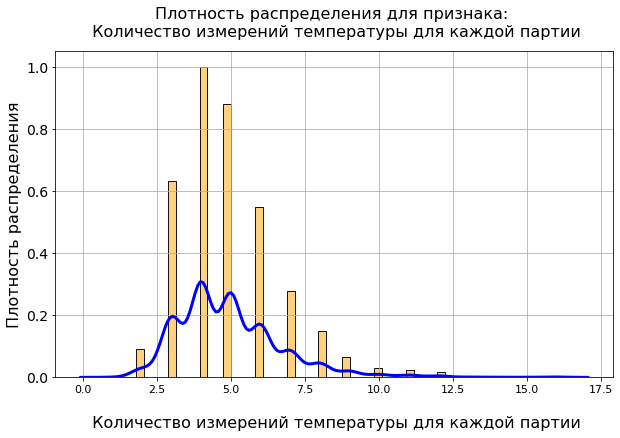

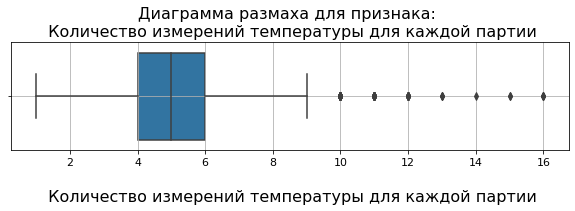

In [18]:
data_info((data_temp
           .groupby('key')['Время замера']
           .agg(['count'])
           ['count']), '\n Количество измерений температуры для каждой партии')

- В среднем около 5 замеров температуры по каждой партии, медиана тоже 5. 
- Но стандартное отклонение около 1,8. 
- Максимально количество замеров достигает **16**, но 75% всех замеров укладываются в 6 шт, что также наглядно видно из графика.
- Минимальное количество заммеров - 1 шт, что для нас не информативно, от таких партий придётся избавиться.
- Также мы помним про 18% пропущенных значений.

Примерно для 18% данных нет значений температуры. Посмотрим, что это за строки таблицы:

In [19]:
data_temp[data_temp['Температура'].isna()==True].head(10)

key        Время замера  Температура
12268  2500 2019-08-06 03:24:43          NaN
12269  2500 2019-08-06 03:25:16          NaN
12270  2500 2019-08-06 03:28:21          NaN
12272  2501 2019-08-06 04:01:59          NaN
12273  2501 2019-08-06 04:14:35          NaN
12274  2501 2019-08-06 04:22:14          NaN
12275  2501 2019-08-06 04:31:14          NaN
12277  2502 2019-08-06 04:46:04          NaN
12278  2502 2019-08-06 04:52:32          NaN
12279  2502 2019-08-06 04:57:30          NaN

Очевидно, что инфомрации нет сразу по нескольким точкам в одной партии, причем в нескольких партиях.

С помощью группировки посмотрим по каким партиям нет измерений:

In [20]:
(
    data_temp[data_temp['Температура'].isna()==True]
    .groupby('key')['Время замера']
    .agg(['count'])
    .info()
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 739 entries, 2500 to 3241
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   739 non-null    int64
dtypes: int64(1)
memory usage: 11.5 KB


Для **739** партий нет измерений температуры, как одного так и нескольких.

В данном случае целесообразно **удалить пропуски**, так как, если мы заполним их, то можем ухудшить качество модели.

Выведем информацию о ключах в таблице `data_temp` перед удалением:

In [21]:
key_info(data_temp['key'])

Количество объектов: 15907
Количество уникальных значений key: 3216
min       1
max    3241
Name: key, dtype: int64


**Удалим пропуски** с помощью `dropna()`:

In [22]:
 data_temp = data_temp.dropna().reset_index(drop=True)

Проверяем количество уникальных `key`:

In [23]:
key_info(data_temp['key'])

Количество объектов: 13006
Количество уникальных значений key: 3216
min       1
max    3241
Name: key, dtype: int64


Количество объектов уменьшилось, но количество уникальных `key` пока что сохранилось.

#### Количество измерений температуры для каждой партии

На предыдущем шаге **мы удалили много пропущенных значений**. Как будет показано далее это привело к увеличению объектов с количеством измерений температуры, равным `1`. Это не информативные для нас объекты, так как мы не будем знать температуру либо начала, либо конца нагрева.

**Удалим партии с одним измерением температуры**. Для этого создадим таблицу, в которой для каждой партии посчитаем количество измерений:

In [24]:
temperature_control_count = (data_temp
                             .groupby('key')['Время замера']
                             .agg(['count'])
                             ['count'].reset_index())

Выведем первые несколько строк:

In [25]:
temperature_control_count.head()

key  count
0    1      5
1    2      6
2    3      5
3    4      3
4    5      2

Ознакомимся с характеристикой выборки для количества измерений **после удаления пропусков**:

 Характеристика выборки для признака:  Количество измерений температуры в процессе нагрева


count    3216.000000
mean        4.044154
std         2.299755
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        16.000000
Name: count, dtype: float64

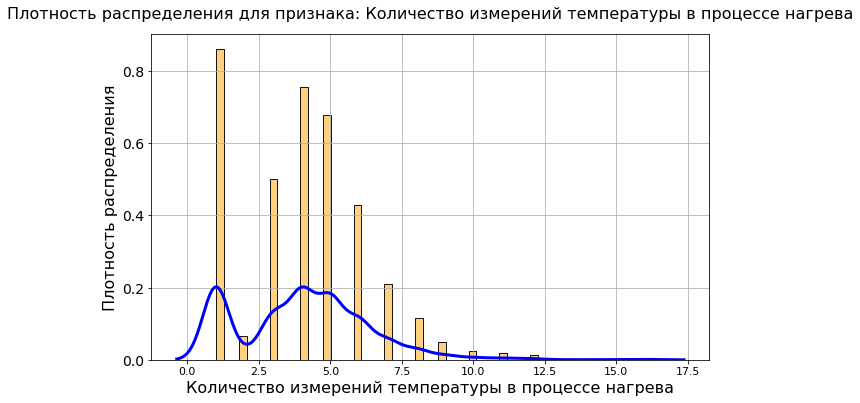

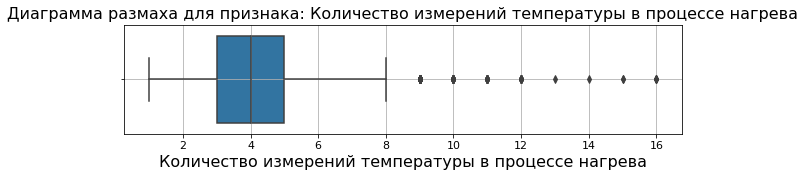

In [26]:
data_info(temperature_control_count['count'], "Количество измерений температуры в процессе нагрева")

Появилось выдающееся значение, равное **1**.

Теперь добавим таблицу `temperature_control_count` к таблице `data_temp`, но перед этим выведем инфомрацию о `data_temp`, чтобы проконтролировать количество пропусков:

In [27]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13006 entries, 0 to 13005
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13006 non-null  int64         
 1   Время замера  13006 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 305.0 KB


Сделаем слияние таблиц с помощью `left` `merge()` по ключу `key`:

In [28]:
data_temp = data_temp.merge(temperature_control_count, how='left', on='key')

Контроль размерности:

In [29]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 13005
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13006 non-null  int64         
 1   Время замера  13006 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
 3   count         13006 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 508.0 KB


Отлично, новый столбец появился, а пропусков не прибавилось.

С помощью **логической индексации** удалим партии с общим количеством измерений равным **1**:

In [30]:
data_temp = data_temp[data_temp['count']!=1].reset_index(drop=True)

Контроль пропусков:

In [31]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12265 entries, 0 to 12264
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           12265 non-null  int64         
 1   Время замера  12265 non-null  datetime64[ns]
 2   Температура   12265 non-null  float64       
 3   count         12265 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 383.4 KB


Пропущенных значений нет.

Как изменилось количество уникальных партий:

In [32]:
key_info(data_temp['key'])

Количество объектов: 12265
Количество уникальных значений key: 2475
min       1
max    2499
Name: key, dtype: int64


Исходно было **3216** партий, осталось **2475**, мы потеряли примерно:

In [33]:
(3216-2475)/3216 * 100

23.041044776119403

Примерно 23% исходных данных, но зато данные, имеющие начальную и конечную точку нагрева.

Проверим результат удаления партий с одним измерением температуры:

In [34]:
(data_temp['count']==1).sum()

0

И снова обратимся к выборке количества измерений температуры:

 Характеристика выборки для признака:  Количество измерений температуры в процессе нагрева


count    12265.000000
mean         5.614431
std          2.141094
min          2.000000
25%          4.000000
50%          5.000000
75%          7.000000
max         16.000000
Name: count, dtype: float64

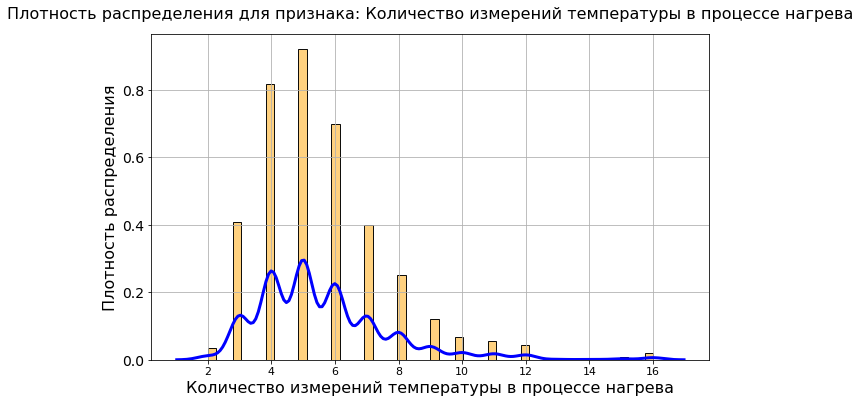

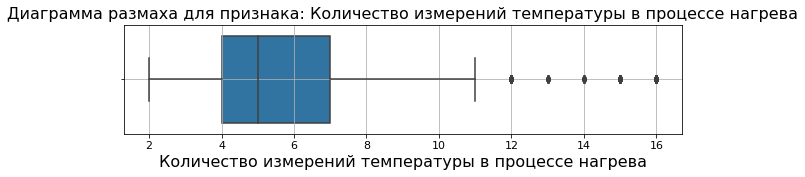

In [35]:
data_info(data_temp['count'], "Количество измерений температуры в процессе нагрева")

Очевидно, что измерение температуры в среднем производится около 6 раз, медиана 5 раз. **Это важный момент**, получается, что прежде чем расплав достигнет искомой температуры, то его текущая температура контролируется **несколько раз** после добавления дополнительных компонентов. **Вероятно, это может помочь в дальнейшем в обучении модели**.

Столбец `count` с количеством замеров пока что не понадобится (но мы вернёмся к нему позднее!), можем его удалить:

In [36]:
data_temp = data_temp.drop('count',axis=1)

Проверка:

In [37]:
data_temp.columns

Index(['key', 'Время замера', 'Температура'], dtype='object')

#### Время первого и последнего измерения

Формат даты и времени был изменён ранее. 

Теперь выделим для каждой партии минимальное и максимальное время замера температуры с помощью `groupby('key')`:

In [38]:
min_max_time = data_temp.groupby('key')['Время замера'].agg(['min','max']).reset_index()
min_max_time.columns = ['key','min_time','max_time']
min_max_time.head()

key            min_time            max_time
0    1 2019-05-03 11:16:18 2019-05-03 11:30:39
1    2 2019-05-03 11:37:27 2019-05-03 11:59:12
2    3 2019-05-03 12:13:17 2019-05-03 12:34:57
3    4 2019-05-03 12:52:57 2019-05-03 12:59:25
4    5 2019-05-03 13:23:19 2019-05-03 13:36:01

Соединяем таблицы:

In [39]:
data_temp = data_temp.merge(min_max_time, how='left', on='key')
data_temp.head()

key        Время замера  Температура            min_time  \
0    1 2019-05-03 11:16:18       1571.0 2019-05-03 11:16:18   
1    1 2019-05-03 11:25:53       1604.0 2019-05-03 11:16:18   
2    1 2019-05-03 11:29:11       1618.0 2019-05-03 11:16:18   
3    1 2019-05-03 11:30:01       1601.0 2019-05-03 11:16:18   
4    1 2019-05-03 11:30:39       1613.0 2019-05-03 11:16:18   

             max_time  
0 2019-05-03 11:30:39  
1 2019-05-03 11:30:39  
2 2019-05-03 11:30:39  
3 2019-05-03 11:30:39  
4 2019-05-03 11:30:39

Теперь мы добавили для каждой партии два признака - минимальное время замера и максимальное. Следующий шаг - выделить среднюю температуру в процессе нагрева, а также температуру начала и окончания нагрева.

#### Средняя температура в процессе нагрева и количество измерений

Чтобы корректно учесть среднюю температуру в процессе нагрева, **нужно исключить из рассмотрения целевой признак - конечную температуру нагрева**. 

Мы сможем сделать это с помощью *сравнения значений в столбцах `Время замера` и `max_time`*:

In [40]:
mean_count_temp = (data_temp[data_temp['Время замера']!=data_temp['max_time']]
                   .groupby('key')['Температура']
                   .agg(['mean','count'])
                   .reset_index())

Меняем названия столбцов:

In [41]:
mean_count_temp.columns = ['key','temperature_mean','count_temp']

Первые строки:

In [42]:
mean_count_temp.head()

key  temperature_mean  count_temp
0    1            1598.5           4
1    2            1591.8           5
2    3            1597.5           4
3    4            1612.0           2
4    5            1576.0           1

Количество измерений определено успешно, а также средняя температура в процессе нагрева (без учета целевого признака).

#### Начальная и конечная температуры нагрева

Создадим столбцы с температурой начала и окончания нагрева.

Выделим значения температуры **начала нагрева для каждой партии**:

In [43]:
temperature_first = (data_temp[data_temp['min_time']==data_temp['Время замера']]
                     [['key', 'Температура']]
                     .reset_index(drop=True))

temperature_first.columns = ['key','temperature_first']

temperature_first.head()

key  temperature_first
0    1             1571.0
1    2             1581.0
2    3             1596.0
3    4             1601.0
4    5             1576.0

Количество уникальных партий:

In [44]:
len(temperature_first['key'].unique())

2475

Отлично, мы не потеряли ни одной уникальной партии.

Выделим значения температуры **окончания нагрева для каждой партии**:

In [45]:
temperature_last = (data_temp[data_temp['max_time']==data_temp['Время замера']]
                    [['key', 'Температура']]
                    .reset_index(drop=True))

temperature_last.columns = ['key','temperature_last']

temperature_last.head()

key  temperature_last
0    1            1613.0
1    2            1602.0
2    3            1599.0
3    4            1625.0
4    5            1602.0

Контроль количества уникальных партий:

In [46]:
len(temperature_last['key'].unique())

2475

Продолжаем без потерь.

Теперь добавим полученные таблицы поочереди к `min_max_time`:

In [47]:
df = min_max_time.merge(temperature_first, how='left', on='key')

In [48]:
df = df.merge(temperature_last, how='left', on='key')

Также добавим среднюю температуру и количество измерений:

In [49]:
df =  df.merge(mean_count_temp, how='left', on='key')

Проверим результат:

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                2475 non-null   int64         
 1   min_time           2475 non-null   datetime64[ns]
 2   max_time           2475 non-null   datetime64[ns]
 3   temperature_first  2475 non-null   float64       
 4   temperature_last   2475 non-null   float64       
 5   temperature_mean   2475 non-null   float64       
 6   count_temp         2475 non-null   int64         
dtypes: datetime64[ns](2), float64(3), int64(2)
memory usage: 154.7 KB


**2475** объектов с начальной и конечной температурами. Признак время пригодится нам для фильтрации, но для обучения мы его удалим.

Прежде чем перейти к дальнейшим шагам посмотрим какие значения температур вошли в итоговый датафрейм:

 Характеристика выборки для признака:  Температура начала нагрева


count    2475.000000
mean     1588.402020
std        29.243044
min      1191.000000
25%      1572.000000
50%      1588.000000
75%      1605.000000
max      1679.000000
Name: temperature_first, dtype: float64

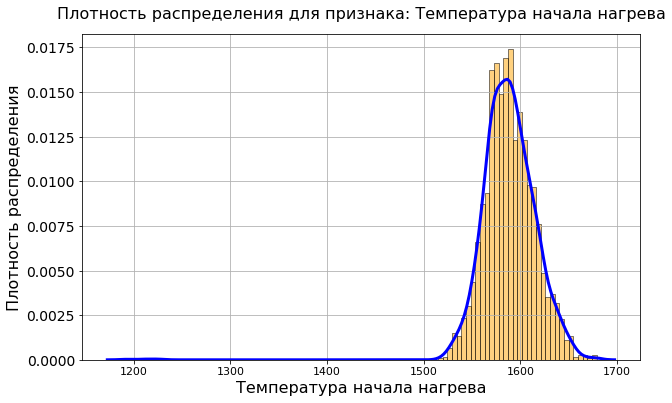

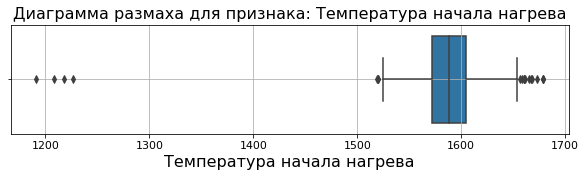

In [51]:
data_info(df['temperature_first'], 'Температура начала нагрева')

Распределение значений температур начала нагрева выглядит равномерным: среднее **1588,4** и медиана **1588** близки, маленькое значение стандартного отклонения (около 1,8% от среднего). Минимум 1191, максимум 1679.

Есть значения примерно на 400 градусов меньше, чем медиана и среднее. Будем иметь это в виду в дальнейшем, если качество модели будет неудовлетворительным: 25% значений меньше 1572 градусов.

Из ящика с усами видно, что есть несколько значений температуры в районе 1200 град. Их мало, настолько мало, что модель врядли научится предсказывать результат по набору с таким малым коилчеством данных.

Так как температура плавления стали в основном находится в диапазоне 1300-1500 град., то можно статистически более внимательно подойти именно к выборке температуры начальна плавления:

In [52]:
q1_temperature_first = df['temperature_first'].quantile(0.25)
q3_temperature_first = df['temperature_first'].quantile(0.75)
iqr_temperature_first = (df['temperature_first'].quantile(0.75)-df['temperature_first'].quantile(0.25))

print('Первый квантиль начальной температуры:', q1_temperature_first)
print('Третий квантиль начальной температуры:', q3_temperature_first)
print('Межквантильный размах:', iqr_temperature_first)

Первый квантиль начальной температуры: 1572.0
Третий квантиль начальной температуры: 1605.0
Межквантильный размах: 33.0


Нижняя граница для выбросов можно считать ($q_1-1.5IQR$) или даже ($q_1-3IQR$), тогда нижняя граница для того, что мы считаем НЕ выбросами, а адекватными данными:

In [53]:
q1_temperature_first-3*iqr_temperature_first

1473.0

Подобные рассуждения применимы для высоких температур:

In [54]:
q3_temperature_first+3*iqr_temperature_first

1704.0

Мы видим, что в большую сторону по диаграмме `boxplot()` требование выполняется.

Следовательно, статистически можно считать данные адекватными, если температура начала нагрева не ниже 1473 град, можем округлить до 1450 град, выполним фильтрацию:

In [55]:
df =df[df['temperature_first']>=1450]

Посмотрим как изменилась характеристика выборки:

 Характеристика выборки для признака:  Температура начала нагрева 
 после удаления выбросов


count    2471.000000
mean     1589.012950
std        25.004369
min      1519.000000
25%      1572.000000
50%      1588.000000
75%      1605.000000
max      1679.000000
Name: temperature_first, dtype: float64

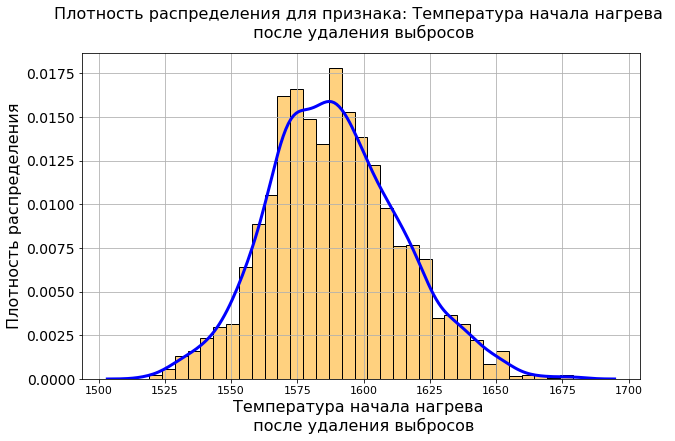

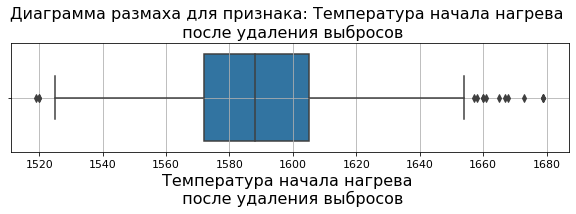

In [56]:
data_info(df['temperature_first'], 'Температура начала нагрева \n после удаления выбросов')

Не требуются дополнительные комментарии, чтобы убедиться, что характеристика выборки улучшилась.

Окончание нагрева:

 Характеристика выборки для признака:  Температура окончания нагрева


count    2471.000000
mean     1595.339943
std        16.035215
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1599.000000
max      1700.000000
Name: temperature_last, dtype: float64

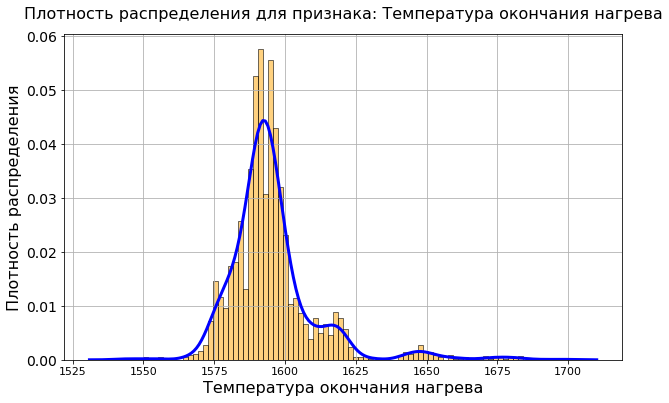

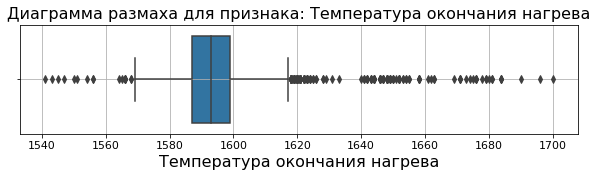

In [57]:
data_info(df['temperature_last'], 'Температура окончания нагрева')

Окончание нагрева выглядит уже не так равномерно, но среднее 1595.3 и медиана 1593 близки, стандартное отклонение 16 меньше, чем в начале нагрева. Минимум 1541, максимум 1700. Оставим отфилтрованную выборку как есть. Это целевой признак, температура здесь - результат нескольких операций, которые нам предстоит учесть дальше.

### Расход инертного газа `data_gas`

Ознакомимся с характеристикой выборки и построим график плотности распределния значений для расхода инертного газа:

 Характеристика выборки для признака:  Расход инертного газа


count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

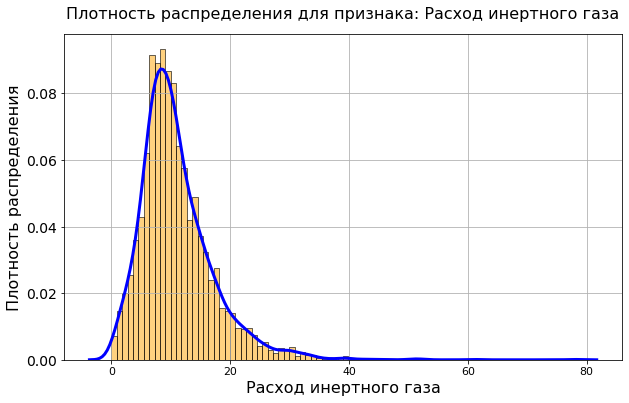

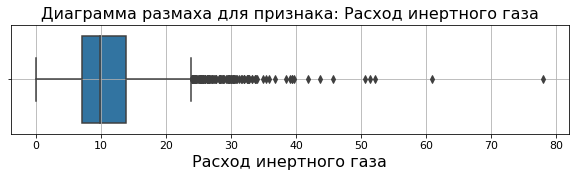

In [58]:
data_info(data_gas['Газ 1'], 'Расход инертного газа')

В среднем расход инертного газа 11, медиана 9,8. Минимум - около 0. Максимум - около 80. Но видно, что это выдающееся значение. Распределение несимметрично, немного скошено вправо. Удалять или отбрасывать никакие значения не будем, так как это результат технологического процесса.

Добавим данный признак к сводному датафрейму. Но сначала улучшим названия столбцов:

In [59]:
data_gas.columns = ['key','inert_gas']

Проверим результат:

In [60]:
data_gas.columns 

Index(['key', 'inert_gas'], dtype='object')

Переходим к добавлению столбца `inert_gas` с помощью метода `merge()`, нам снова подходит тип `left`:

In [61]:
df = df.merge(data_gas, how='left', on='key')

Добавление прошло успешно, но появилось два пропуска:

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 0 to 2470
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                2471 non-null   int64         
 1   min_time           2471 non-null   datetime64[ns]
 2   max_time           2471 non-null   datetime64[ns]
 3   temperature_first  2471 non-null   float64       
 4   temperature_last   2471 non-null   float64       
 5   temperature_mean   2471 non-null   float64       
 6   count_temp         2471 non-null   int64         
 7   inert_gas          2469 non-null   float64       
dtypes: datetime64[ns](2), float64(4), int64(2)
memory usage: 173.7 KB


Значит в таблице `data_gas` не было информации о подаче нейтрального газа для двух партий:

In [63]:
df[df['inert_gas'].isna()==True]

key            min_time            max_time  temperature_first  \
190  193 2019-05-10 11:48:54 2019-05-10 12:30:21             1593.0   
255  259 2019-05-13 02:53:38 2019-05-13 03:11:38             1577.0   

     temperature_last  temperature_mean  count_temp  inert_gas  
190            1595.0       1588.333333           6        NaN  
255            1590.0       1577.500000           2        NaN

Это действительно так:

In [64]:
data_gas[data_gas['key'].isin([193,259])]

Empty DataFrame
Columns: [key, inert_gas]
Index: []

Так как этих значений мало, то удалим партии с пропусками:

In [65]:
df = df.dropna().reset_index(drop=True)

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2469 entries, 0 to 2468
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                2469 non-null   int64         
 1   min_time           2469 non-null   datetime64[ns]
 2   max_time           2469 non-null   datetime64[ns]
 3   temperature_first  2469 non-null   float64       
 4   temperature_last   2469 non-null   float64       
 5   temperature_mean   2469 non-null   float64       
 6   count_temp         2469 non-null   int64         
 7   inert_gas          2469 non-null   float64       
dtypes: datetime64[ns](2), float64(4), int64(2)
memory usage: 154.4 KB


Посмотрим как изменилась выборка расхода инертного газа после фильтрации:

 Характеристика выборки для признака:  Расход инертного газа 
 для выбранных партий


count    2469.000000
mean       11.145730
std         6.327159
min         0.008399
25%         7.105241
50%         9.926730
75%        13.872686
max        77.995040
Name: inert_gas, dtype: float64

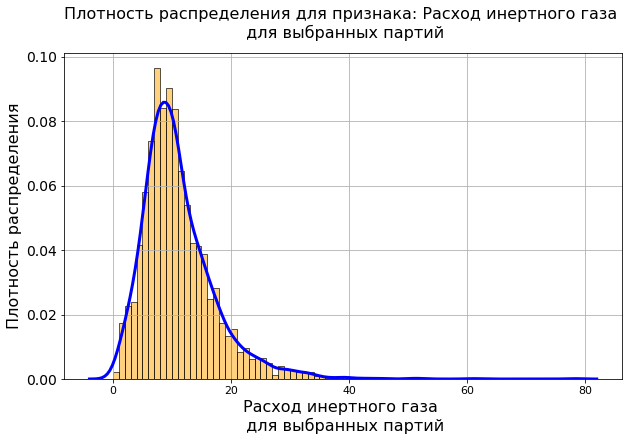

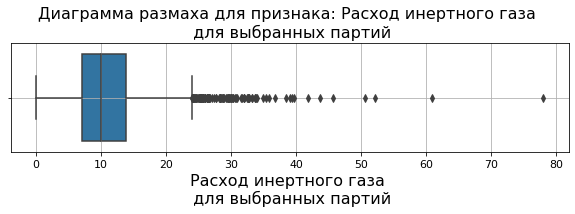

In [67]:
data_info(df['inert_gas'], 'Расход инертного газа \n для выбранных партий')

Скошенность сохранилась, но медиана и среднее значение немного сблизились, стандартное отклонение немного увеличилось. Принципиально ничего не поменялось.

Переходим к активной мощности.

### Активная мощность

Вспомним названия столбцов в таблице `data_arc`:

In [68]:
data_arc.columns

Index(['key', 'Начало нагрева дугой', 'Конец нагрева дугой',
       'Активная мощность', 'Реактивная мощность'],
      dtype='object')

Переведём признаки, связанные с временем к корректному формату данных:

In [69]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], 
                                                  format='%Y-%m-%d %H:%M:%S')

In [70]:
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], 
                                                  format='%Y-%m-%d %H:%M:%S')

Посмотрим как распределены значения электрической энергии для разового нагрева (мы помним, что нагрев может повторяться несколько раз):

 Характеристика выборки для признака:  
 Активная мощность на разовый нагрев 
 в исходном наборе данных


count    14876.000000
mean         0.670441
std          0.408159
min          0.030002
25%          0.395297
50%          0.555517
75%          0.857034
max          3.731596
Name: Активная мощность, dtype: float64

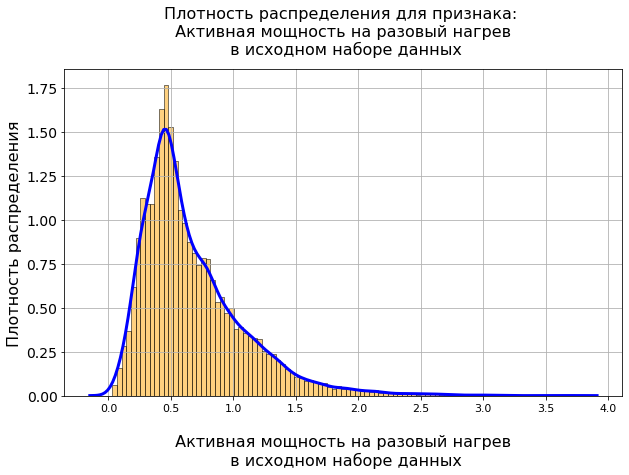

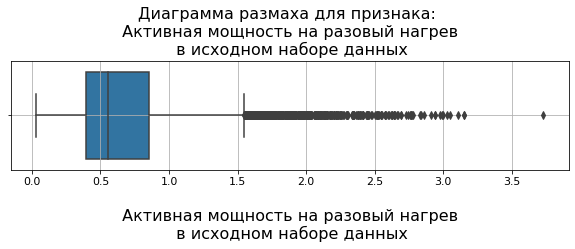

In [71]:
data_info(data_arc['Активная мощность'], 
          '\n Активная мощность на разовый нагрев \n в исходном наборе данных')

В среднем за одну итерацию нагрева затрачивается около 0.67 (условных МВтч). Медиана около 0.50. Но нас будет интересовать сумма всех итераций нагрева.

Реактивную мощность мы не рассматриваем (по факту это потери, а также она коррелирует с активной), поэтому можем её удалить:

In [72]:
data_arc = data_arc.drop('Реактивная мощность',axis=1)

Чтобы отфильтровать активную мощность по времени измерения температуры, добавим столбцы с начальным и конечным временем измерений. Подойдёт тип слияния `inner`, так как таблица `min_max_time` уже отфильтрована по нужным нам `key`:

In [73]:
data_arc = data_arc.merge(min_max_time, how='inner', on='key')

Пропусков не прибавилось:

In [74]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11449 entries, 0 to 11448
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   11449 non-null  int64         
 1   Начало нагрева дугой  11449 non-null  datetime64[ns]
 2   Конец нагрева дугой   11449 non-null  datetime64[ns]
 3   Активная мощность     11449 non-null  float64       
 4   min_time              11449 non-null  datetime64[ns]
 5   max_time              11449 non-null  datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1)
memory usage: 626.1 KB


С помощью логической индексации исключим строки, в которых начальное или конечное время измерений превышает **время окончания измерения**:

In [75]:
data_arc = data_arc[(data_arc['Начало нагрева дугой']<=data_arc['max_time']) |
                    (data_arc['Конец нагрева дугой']<=data_arc['max_time'])]

Пропусков не прибавилось и отсеялось не так много строк:

In [76]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11315 entries, 0 to 11448
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   11315 non-null  int64         
 1   Начало нагрева дугой  11315 non-null  datetime64[ns]
 2   Конец нагрева дугой   11315 non-null  datetime64[ns]
 3   Активная мощность     11315 non-null  float64       
 4   min_time              11315 non-null  datetime64[ns]
 5   max_time              11315 non-null  datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1)
memory usage: 618.8 KB


Теперь можем посчитать суммарную **электрическую энергию, затраченную на каждую партию** (по активной мощности), а также **количество операций нагрева**:

In [77]:
electric_energy = data_arc.groupby('key')['Активная мощность'].agg(['sum','count']).reset_index()

electric_energy.columns = ['key', 'electric_energy','count_heating']

electric_energy.head()

key  electric_energy  count_heating
0    1         4.878147              5
1    2         3.052598              4
2    3         2.525882              5
3    4         3.209250              4
4    5         3.347173              4

И добавим её к сводному датафрему:

In [78]:
df = df.merge(electric_energy, how='left', on='key')

Посмотрим не прибавилось ли пропусков:

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2469 entries, 0 to 2468
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                2469 non-null   int64         
 1   min_time           2469 non-null   datetime64[ns]
 2   max_time           2469 non-null   datetime64[ns]
 3   temperature_first  2469 non-null   float64       
 4   temperature_last   2469 non-null   float64       
 5   temperature_mean   2469 non-null   float64       
 6   count_temp         2469 non-null   int64         
 7   inert_gas          2469 non-null   float64       
 8   electric_energy    2469 non-null   float64       
 9   count_heating      2469 non-null   int64         
dtypes: datetime64[ns](2), float64(5), int64(3)
memory usage: 212.2 KB


Всё чётко, потому что мы использовали уже отфильтрованный по `key` датафрейм.

Посмотрим характеристику выборки для нового признака `electric_energy`:

 Характеристика выборки для признака:  Суммарные затраты электроэнергии на партию


count    2469.000000
mean        3.116088
std         1.427433
min         0.186226
25%         2.139525
50%         3.001595
75%         3.904337
max        17.496497
Name: electric_energy, dtype: float64

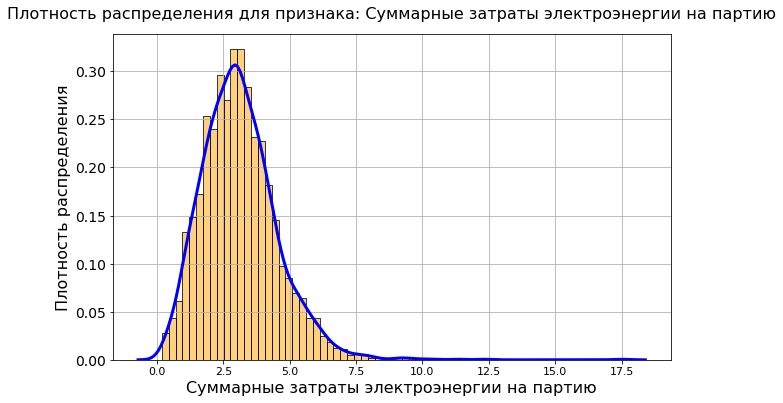

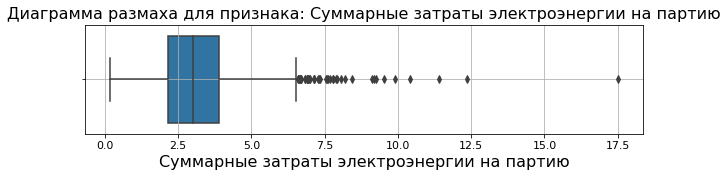

In [80]:
data_info(df['electric_energy'], 
          'Суммарные затраты электроэнергии на партию')

Суммарные затраты электроэнергии на партию распределены в выборке равномернее, чем для разового нагрева, так как медиана и среднее близки. Есть большие значения электроэнергии (свыше 7,5 условных МВтч), но пока что удалять их не будем. Если качество модели будет неудовлитворительное, то будем использовать это как потенциальную зона роста.

### Сыпучие материалы

Количество ключей в таблицах сыпучих материалов:

In [81]:
 key_info(data_bulk['key'])

Количество объектов: 3129
Количество уникальных значений key: 3129
min       1
max    3241
Name: key, dtype: int64


In [82]:
 key_info(data_bulk_time['key'])

Количество объектов: 3129
Количество уникальных значений key: 3129
min       1
max    3241
Name: key, dtype: int64


Таблицы с данными о сыпучих материалах неочень удобны для вычислений:

In [83]:
data_bulk.head()

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

In [84]:
data_bulk_time.head()

key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:21:30    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:46:38    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:31:06    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:48:43    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:18:50    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:03:52     NaN  2019-05-03 11:03:52   
1    NaN     NaN     NaN  2019-05-03 11:40:20     NaN  2019-05-03 11:40:20   
2    NaN     NaN     NaN  2019-05-03 12:09:40     NaN  2019-05-03 12:09:40   
3    NaN     NaN     NaN  2019-05-03 12:41:24     NaN  2019-05-03 12:41:24   
4    NaN     NaN     NaN  2019-05-03 13:12:56     NaN  2019-05-03 13:12:56   

               Bulk 15  
0  2019-05-03 11:03:52  
1  2019-05-03 11:40:20  
2  2019-05-03 12:09:40  
3  2019-05-03 12:41:24  
4  2019-05-03 13:12:56

Размерность этих двух таблиц, как мы помним, одинаковая:

In [85]:
data_bulk_time.shape

(3129, 16)

In [86]:
data_bulk.shape

(3129, 16)

Также отсутствуют партии для которых не было загрузки сыпучих:

In [87]:
data_bulk.sum(axis=1).reset_index().sort_values(by=0).head(10)

index      0
25     25   93.0
70     70  135.0
99     99  135.0
92     92  158.0
46     46  206.0
93     93  207.0
66     66  209.0
65     65  216.0
45     45  220.0
47     47  235.0

Приведём их к **"длинному"** виду.

Для этого сначала перейдём к мультииндексации, чтобы после функции `stack()` получить таблицу типа `DataFrame`.

Названия столбцов для мультииндекса:

In [88]:
array = ['key']
for i in range(1,(data_bulk.shape[1])):
    array.append('bulk')
array = [array,data_bulk.columns]

Присваиваем мультииндексы:

In [89]:
data_bulk.columns = pd.MultiIndex.from_arrays(array)

Смотрим результат:

In [90]:
data_bulk.head()

key   bulk                                                                  \
  key Bulk 1 Bulk 2 Bulk 3 Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8 Bulk 9 Bulk 10   
0   1    NaN    NaN    NaN   43.0    NaN    NaN    NaN    NaN    NaN     NaN   
1   2    NaN    NaN    NaN   73.0    NaN    NaN    NaN    NaN    NaN     NaN   
2   3    NaN    NaN    NaN   34.0    NaN    NaN    NaN    NaN    NaN     NaN   
3   4    NaN    NaN    NaN   81.0    NaN    NaN    NaN    NaN    NaN     NaN   
4   5    NaN    NaN    NaN   78.0    NaN    NaN    NaN    NaN    NaN     NaN   

                                           
  Bulk 11 Bulk 12 Bulk 13 Bulk 14 Bulk 15  
0     NaN   206.0     NaN   150.0   154.0  
1     NaN   206.0     NaN   149.0   154.0  
2     NaN   205.0     NaN   152.0   153.0  
3     NaN   207.0     NaN   153.0   154.0  
4     NaN   203.0     NaN   151.0   152.0

Теперь выполяем операцию `stack()`, с помощью которой по умолчанию удаляются пропуски:

In [91]:
#делаем операцию `stack`, назначив иднексом столбец ('key','key')
data_bulk_stacked = data_bulk.set_index(('key','key')).stack().reset_index()

#меняем названия столбцов для удобства
data_bulk_stacked.columns = ['key','bulk_number','volume_bulk']

#выводим первые 5 строк
data_bulk_stacked.head()

key bulk_number  volume_bulk
0    1     Bulk 12        206.0
1    1     Bulk 14        150.0
2    1     Bulk 15        154.0
3    1      Bulk 4         43.0
4    2     Bulk 12        206.0

Важно, что выполненная операция не привела к потере уникальных ключей:

In [92]:
key_info(data_bulk_stacked['key'])

Количество объектов: 11159
Количество уникальных значений key: 3129
min       1
max    3241
Name: key, dtype: int64


Проверим нет ли потерь среди номера `bulk` и увидим, что всё на месте:

In [93]:
data_bulk_stacked['bulk_number'].value_counts()

Bulk 14    2806
Bulk 12    2450
Bulk 15    2248
Bulk 3     1298
Bulk 4     1014
Bulk 6      576
Bulk 1      252
Bulk 11     177
Bulk 10     176
Bulk 5       77
Bulk 7       25
Bulk 2       22
Bulk 9       19
Bulk 13      18
Bulk 8        1
Name: bulk_number, dtype: int64

Таблица приобрела "длинный" вид, для каждой партии есть информация о номере `bulk` и объёме, а также теперь нет пропущенных значений:

In [94]:
data_bulk_stacked.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11159 entries, 0 to 11158
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          11159 non-null  int64  
 1   bulk_number  11159 non-null  object 
 2   volume_bulk  11159 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 261.7+ KB


Сделаем аналогичные операции с таблицей `data_bulk_time`:

Так как нам предстоит делать те же операции и для проволоки, то запишем их в виде функции:

In [95]:
def stack_func(data,name_array):
    
    #переходим к мультииндексации
    data.columns = pd.MultiIndex.from_arrays(array)

    #делаем операцию `stack`, назначив иднексом столбец ('key','key')
    data_stacked = data.set_index(('key','key')).stack().reset_index()
    
    #меняем названия столбцов для удобства
    data_stacked.columns = name_array
    
    return data_stacked

Преобразуем таблицу `data_bulk_time`:

In [96]:
data_bulk_time_stacked = stack_func(data_bulk_time,
                                    ['key','bulk_number','time_bulk'])

Первые строки:

In [97]:
data_bulk_time_stacked.head()

key bulk_number            time_bulk
0    1     Bulk 12  2019-05-03 11:03:52
1    1     Bulk 14  2019-05-03 11:03:52
2    1     Bulk 15  2019-05-03 11:03:52
3    1      Bulk 4  2019-05-03 11:21:30
4    2     Bulk 12  2019-05-03 11:40:20

Контроль уникальных значений:

In [98]:
key_info(data_bulk_time_stacked['key'])

Количество объектов: 11159
Количество уникальных значений key: 3129
min       1
max    3241
Name: key, dtype: int64


И отсутствие пропусков:

In [99]:
data_bulk_time_stacked.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11159 entries, 0 to 11158
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   key          11159 non-null  int64 
 1   bulk_number  11159 non-null  object
 2   time_bulk    11159 non-null  object
dtypes: int64(1), object(2)
memory usage: 261.7+ KB


Теперь можем сделать слияние двух таблиц:

In [100]:
data_bulk_full = data_bulk_stacked.merge(data_bulk_time_stacked, 
                                         how='left', 
                                         on=['key','bulk_number'])

In [101]:
data_bulk_full.head()

key bulk_number  volume_bulk            time_bulk
0    1     Bulk 12        206.0  2019-05-03 11:03:52
1    1     Bulk 14        150.0  2019-05-03 11:03:52
2    1     Bulk 15        154.0  2019-05-03 11:03:52
3    1      Bulk 4         43.0  2019-05-03 11:21:30
4    2     Bulk 12        206.0  2019-05-03 11:40:20

Ещё раз проверим уникальные ключи:

In [102]:
key_info(data_bulk_full['key'])

Количество объектов: 11159
Количество уникальных значений key: 3129
min       1
max    3241
Name: key, dtype: int64


Отлично, три предыдущих шага выполнены аккуратно, потерей среди уникальных ключей нет.

Количество строк в итоговой таблице соответсвует количеству строк двух исходных:

In [103]:
data_bulk_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11159 entries, 0 to 11158
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          11159 non-null  int64  
 1   bulk_number  11159 non-null  object 
 2   volume_bulk  11159 non-null  float64
 3   time_bulk    11159 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 435.9+ KB


Мы получили таблицу без пропущенных значений, в которой для каждой партии есть данные о номере `bulk`, а также об объёме и времени загрузки. Теперь мы можем выбрать только тот загруженный объём, который был загружен не позднее последнего измерения температуры. А затем сделаем группировку по каждой партии, после чего добавим инфомрацию о суммарном объёме сыпучих для каждой партии в сводный датафрейм.

Начнем с добавления таблицы времени начала и конца измерений:

In [104]:
data_bulk_full = data_bulk_full.merge(min_max_time, 
                                      how='left', 
                                      on=['key'])

Проверим результат:

In [105]:
#выведем первые строки
data_bulk_full.head()

key bulk_number  volume_bulk            time_bulk            min_time  \
0    1     Bulk 12        206.0  2019-05-03 11:03:52 2019-05-03 11:16:18   
1    1     Bulk 14        150.0  2019-05-03 11:03:52 2019-05-03 11:16:18   
2    1     Bulk 15        154.0  2019-05-03 11:03:52 2019-05-03 11:16:18   
3    1      Bulk 4         43.0  2019-05-03 11:21:30 2019-05-03 11:16:18   
4    2     Bulk 12        206.0  2019-05-03 11:40:20 2019-05-03 11:37:27   

             max_time  
0 2019-05-03 11:30:39  
1 2019-05-03 11:30:39  
2 2019-05-03 11:30:39  
3 2019-05-03 11:30:39  
4 2019-05-03 11:59:12

Выведем размерность перед фильтрацией:

In [106]:
#посмотрим размерность
data_bulk_full.shape

(11159, 6)

И количество уникальных ключей:

In [107]:
key_info(data_bulk_full['key'])

Количество объектов: 11159
Количество уникальных значений key: 3129
min       1
max    3241
Name: key, dtype: int64


Отфильтруем таблицу: **избавимся от добавок сыпучих, которые были загружены позднее времени крайнего измерения температуры**. Для этого воспользуемся логической индексацией:

In [108]:
data_bulk_full = data_bulk_full[data_bulk_full['time_bulk'] <data_bulk_full['max_time']].reset_index(drop=True)
data_bulk_full.head()

key bulk_number  volume_bulk            time_bulk            min_time  \
0    1     Bulk 12        206.0  2019-05-03 11:03:52 2019-05-03 11:16:18   
1    1     Bulk 14        150.0  2019-05-03 11:03:52 2019-05-03 11:16:18   
2    1     Bulk 15        154.0  2019-05-03 11:03:52 2019-05-03 11:16:18   
3    1      Bulk 4         43.0  2019-05-03 11:21:30 2019-05-03 11:16:18   
4    2     Bulk 12        206.0  2019-05-03 11:40:20 2019-05-03 11:37:27   

             max_time  
0 2019-05-03 11:30:39  
1 2019-05-03 11:30:39  
2 2019-05-03 11:30:39  
3 2019-05-03 11:30:39  
4 2019-05-03 11:59:12

Сколько осталось уникальных ключей после фильтрации:

In [109]:
key_info(data_bulk_full['key'])

Количество объектов: 8525
Количество уникальных значений key: 2403
min       1
max    2499
Name: key, dtype: int64


Снова проверяем размерность:

In [110]:
#посмотрим размерность
data_bulk_full.shape

(8525, 6)

Мы видим, что нам удалось избавиться от достаточно большого количества значений, которые могли исказить наши результаты:

In [111]:
(11159-8525)/11159*100

23.604265615198493

**23% значений**, которые не вписывались в наши условия. Это врядли могло пройти бесследно.

Прежде чем перейти к суммированию добавок сыпучих выведем инфомрацию о разовой добавке:

 Характеристика выборки для признака:  Объём разовой загрузки сыпучих


count    8525.000000
mean      170.357654
std       100.325882
min         1.000000
25%       103.000000
50%       154.000000
75%       206.000000
max      1849.000000
Name: volume_bulk, dtype: float64

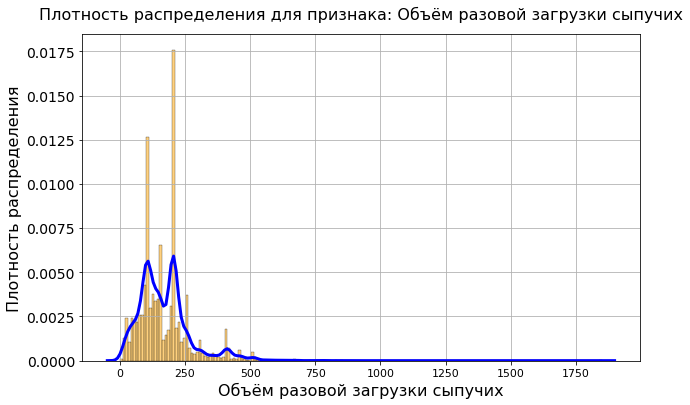

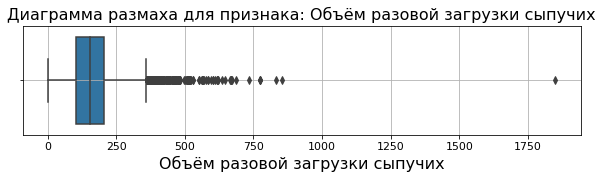

In [112]:
data_info(data_bulk_full['volume_bulk'], 'Объём разовой загрузки сыпучих')

- Среднее 170,35 и медиана 154 разовой загрузки сыпучих отличаются.
- Максимальная загрузка достигала 1849.
- Минимальная загрузка 1.
- достаточно много значений, судя по графику, около 200.
- это также подтверждается характеристикой выборки - 75% значений менее 206.

Мы помним, что мы сделали фильтрацию по времени загрузки. Значит по всем приведенным партиям у нас есть информация об объёме загрузки сыпучих. Часть мы отфильтруем также с помощью температуры.

Идём дальше. Осталось сгруппировать таблицу `data_bulk_full` по партии и **просуммировать объём** и посчитать **количество операций подачи сыпучих для каждой партии**, столбцы со временем и номером `bulk` нам больше не понадобятся:

In [113]:
data_bulk_full = data_bulk_full.groupby('key')['volume_bulk'].agg(['sum','count']).reset_index()
data_bulk_full.columns = ['key','volume_bulk','count_bulk']
data_bulk_full.head()

key  volume_bulk  count_bulk
0    1        553.0           4
1    2        582.0           4
2    3        544.0           4
3    4        595.0           4
4    5        584.0           4

Очевидно, что операция выполнена успешно.

Ознакомимся с характеристикой выборки нового признака:

 Характеристика выборки для признака:  
 Объём суммарной загрузки сыпучих на партию 
 до фильтрации по пропускам температуры


count    2403.000000
mean      604.369122
std       286.790377
min        19.000000
25%       430.500000
50%       604.000000
75%       789.000000
max      3235.000000
Name: volume_bulk, dtype: float64

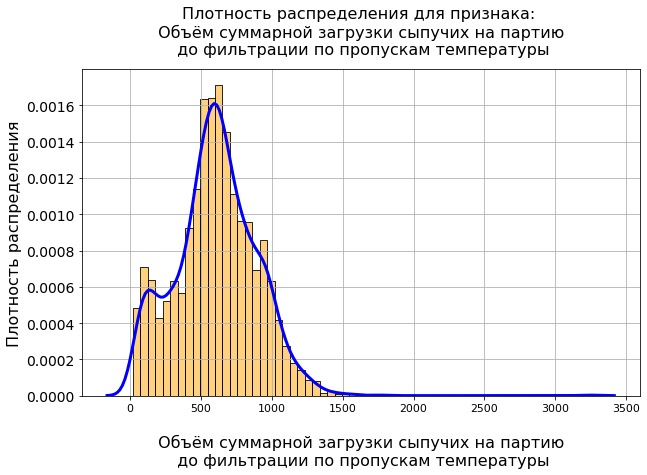

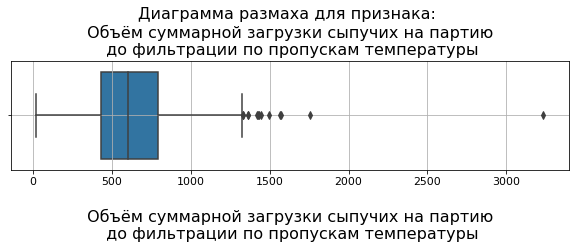

In [114]:
data_info(data_bulk_full['volume_bulk'], 
          '\n Объём суммарной загрузки сыпучих на партию \n до фильтрации по пропускам температуры')

Очевидно, что суммирование сглаживает распределение: медиана 604 и среднее 604,4 близки. Также видно, что у графика есть один явный пик в районе 700 и менее явных: примерно около 100 и 1000.

In [115]:
df.shape

(2469, 10)

In [116]:
data_bulk_full.shape

(2403, 3)

Последний штрих для сыпучих - добавляем объём сыпучих и количество операций загрузки в сводный датафрейм `df`. Будем использовать тип слияния `inner`, так как объём сыпучих - важная характеристика,  а количество партий в двух таблицах различаются незначительно:

In [117]:
df = df.merge(data_bulk_full,
              how='inner',
              on=['key'])

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2397 entries, 0 to 2396
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                2397 non-null   int64         
 1   min_time           2397 non-null   datetime64[ns]
 2   max_time           2397 non-null   datetime64[ns]
 3   temperature_first  2397 non-null   float64       
 4   temperature_last   2397 non-null   float64       
 5   temperature_mean   2397 non-null   float64       
 6   count_temp         2397 non-null   int64         
 7   inert_gas          2397 non-null   float64       
 8   electric_energy    2397 non-null   float64       
 9   count_heating      2397 non-null   int64         
 10  volume_bulk        2397 non-null   float64       
 11  count_bulk         2397 non-null   int64         
dtypes: datetime64[ns](2), float64(6), int64(4)
memory usage: 243.4 KB


По графику и характеристикам выборки видим, что существенных изменений после дополнительной фильтрации нет: 

 Характеристика выборки для признака:  
 Объём суммарной загрузки сыпучих на партию


count    2397.000000
mean      604.659157
std       286.874986
min        19.000000
25%       430.000000
50%       604.000000
75%       790.000000
max      3235.000000
Name: volume_bulk, dtype: float64

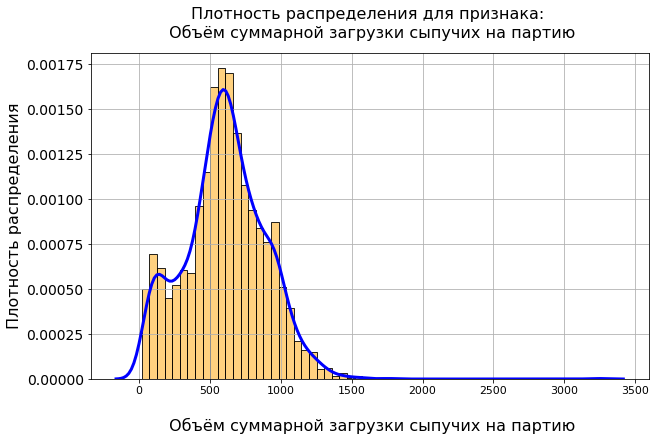

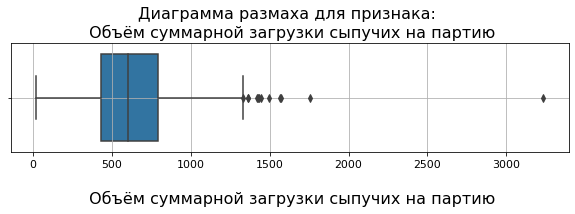

In [119]:
data_info(df['volume_bulk'], '\n Объём суммарной загрузки сыпучих на партию')

### Проволока

Рассуждения, касающиеся проволоки, аналогичны подробно описанным выше для сыпучих. 

Поэтому в данном разделе будем **более лаконичны** и пошагово добавим **объём проволоки** и **количество операций её загрузки для каждой партии** в сводный датафрейм с предварительной фильтрацией.

- **Количество ключей** в таблицах загрузки проволоки:

In [120]:
 key_info(data_wire['key'])

Количество объектов: 3081
Количество уникальных значений key: 3081
min       1
max    3241
Name: key, dtype: int64


In [121]:
 key_info(data_wire_time['key'])

Количество объектов: 3081
Количество уникальных значений key: 3081
min       1
max    3241
Name: key, dtype: int64


- **Первые строки:**

In [122]:
data_wire.head()

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

In [123]:
data_wire_time.head()

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:11:41                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:46:10                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:13:47                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:48:05                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:18:15  2019-05-03 13:32:06    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN

- Массив с **названием столбцов** для мультииндекса:

In [124]:
array = ['key']
for i in range(1,(data_wire.shape[1])):
    array.append('wire')
array = [array, data_wire.columns]

- **Операция `stack()`** с помощью ранее созданной функции и её результаты:

In [125]:
data_wire_stacked = stack_func(data_wire,
                               ['key','wire_number','volume_wire'])

In [126]:
data_wire_time_stacked = stack_func(data_wire_time,
                                    ['key','wire_number','time_wire'])

In [127]:
data_wire_stacked.head()

key wire_number  volume_wire
0    1      Wire 1    60.059998
1    2      Wire 1    96.052315
2    3      Wire 1    91.160157
3    4      Wire 1    89.063515
4    5      Wire 1    89.238236

In [128]:
data_wire_time_stacked.head()

key wire_number            time_wire
0    1      Wire 1  2019-05-03 11:11:41
1    2      Wire 1  2019-05-03 11:46:10
2    3      Wire 1  2019-05-03 12:13:47
3    4      Wire 1  2019-05-03 12:48:05
4    5      Wire 1  2019-05-03 13:18:15

- **Повторный контроль** уникальных значений:

In [129]:
key_info(data_wire_stacked['key'])

Количество объектов: 4344
Количество уникальных значений key: 3081
min       1
max    3241
Name: key, dtype: int64


In [130]:
key_info(data_wire_time_stacked['key'])

Количество объектов: 4344
Количество уникальных значений key: 3081
min       1
max    3241
Name: key, dtype: int64


In [131]:
data_wire_stacked['wire_number'].value_counts().reset_index().sort_values(by='index')

index  wire_number
0  Wire 1         3055
1  Wire 2         1079
3  Wire 3           63
6  Wire 4           14
8  Wire 5            1
2  Wire 6           73
7  Wire 7           11
5  Wire 8           19
4  Wire 9           29

- **Объединение двух таблиц `data_wire_stacked` и `data_wire_time_stacked`:**

In [132]:
data_wire_full = data_wire_stacked.merge(data_wire_time_stacked, 
                                         how='left', 
                                         on=['key','wire_number'])

In [133]:
data_wire_full.head()

key wire_number  volume_wire            time_wire
0    1      Wire 1    60.059998  2019-05-03 11:11:41
1    2      Wire 1    96.052315  2019-05-03 11:46:10
2    3      Wire 1    91.160157  2019-05-03 12:13:47
3    4      Wire 1    89.063515  2019-05-03 12:48:05
4    5      Wire 1    89.238236  2019-05-03 13:18:15

Уникальные ключи не потеряли:

In [134]:
key_info(data_wire_full['key'])

Количество объектов: 4344
Количество уникальных значений key: 3081
min       1
max    3241
Name: key, dtype: int64


- **Добавляем таблицу `min_max_time` для контроля времени:**

In [135]:
data_wire_full = data_wire_full.merge(min_max_time, 
                                      how='left', 
                                      on=['key'])

In [136]:
data_wire_full.head()

key wire_number  volume_wire            time_wire            min_time  \
0    1      Wire 1    60.059998  2019-05-03 11:11:41 2019-05-03 11:16:18   
1    2      Wire 1    96.052315  2019-05-03 11:46:10 2019-05-03 11:37:27   
2    3      Wire 1    91.160157  2019-05-03 12:13:47 2019-05-03 12:13:17   
3    4      Wire 1    89.063515  2019-05-03 12:48:05 2019-05-03 12:52:57   
4    5      Wire 1    89.238236  2019-05-03 13:18:15 2019-05-03 13:23:19   

             max_time  
0 2019-05-03 11:30:39  
1 2019-05-03 11:59:12  
2 2019-05-03 12:34:57  
3 2019-05-03 12:59:25  
4 2019-05-03 13:36:01

- **Отфильтруем таблицу `data_wire_full`:**

**Избавимся от добавок проволоки, которые были загружены позднее времени крайнего измерения температуры**. 

Для этого воспользуемся логической индексацией:

In [137]:
data_wire_full = data_wire_full[data_wire_full['time_wire'] <data_wire_full['max_time']].reset_index(drop=True)
data_wire_full.head()

key wire_number  volume_wire            time_wire            min_time  \
0    1      Wire 1    60.059998  2019-05-03 11:11:41 2019-05-03 11:16:18   
1    2      Wire 1    96.052315  2019-05-03 11:46:10 2019-05-03 11:37:27   
2    3      Wire 1    91.160157  2019-05-03 12:13:47 2019-05-03 12:13:17   
3    4      Wire 1    89.063515  2019-05-03 12:48:05 2019-05-03 12:52:57   
4    5      Wire 1    89.238236  2019-05-03 13:18:15 2019-05-03 13:23:19   

             max_time  
0 2019-05-03 11:30:39  
1 2019-05-03 11:59:12  
2 2019-05-03 12:34:57  
3 2019-05-03 12:59:25  
4 2019-05-03 13:36:01

Сколько осталось уникальных ключей после фильтрации:

In [138]:
key_info(data_wire_full['key'])

Количество объектов: 3319
Количество уникальных значений key: 2371
min       1
max    2499
Name: key, dtype: int64


Мы избавились примерно от 23% значений, которые могли исказить результаты:

In [139]:
(4344-3319)/4344*100

23.59576427255985

Количество уникальных значений для номера партий сократилось с **3081 до 2371**, но это не критично, лучше обучать модели на максимально надёжных данных.

- **Исследование выборки объёма разовой загрузки проволоки**

Прежде чем перейти к суммированию добавок сыпучих выведем инфомрацию о разовой добавке:

 Характеристика выборки для признака:  Объём разовой загрузки проволоки


count    3319.000000
mean       89.469911
std        50.242216
min         0.030160
25%        50.993279
50%        90.136795
75%       120.182400
max       385.008668
Name: volume_wire, dtype: float64

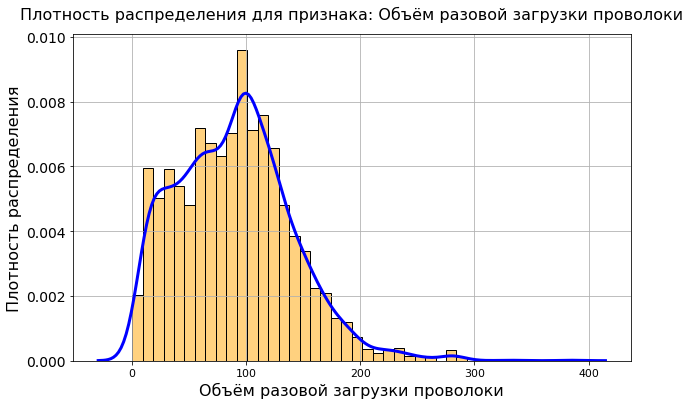

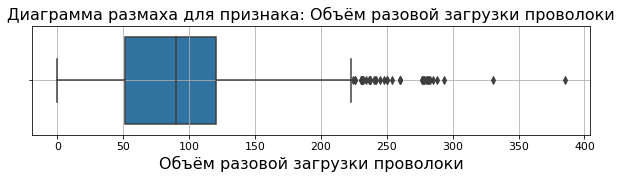

In [140]:
data_info(data_wire_full['volume_wire'], 'Объём разовой загрузки проволоки')

- Среднее 89.46 и медиана 90 разовой загрузки проволоки близки.
- Максимальная загрузка достигала 385.
- Минимальная загрузка близка к нулю.
- пик количества значений, судя по графику, около 100, менее явный пик в районе 40-50.
- это также подтверждается характеристикой выборки - 75% значений менее 120.

- Осталось сгруппировать таблицу `data_wire_full` по партии и **просуммировать объём и посчитать количество операций загрузки проволоки для каждой партии**, столбцы со временем и номером `wire` нам больше не понадобятся:

In [141]:
data_wire_full = data_wire_full.groupby('key')['volume_wire'].agg(['sum','count']).reset_index()
data_wire_full.columns = ['key','volume_wire','count_wire']
data_wire_full.head()

key  volume_wire  count_wire
0    1    60.059998           1
1    2    96.052315           1
2    3    91.160157           1
3    4    89.063515           1
4    5    98.352796           2

Очевидно, что операция выполнена успешно.

Ознакомимся с характеристикой выборки нового признака:

 Характеристика выборки для признака:  
 Объём суммарной загрузки проволоки на партию 
 (до фильтрации по пропускам температуры)


count    2371.000000
mean      125.242781
std        64.035997
min         1.918800
25%        88.230999
50%       116.101440
75%       151.635117
max       568.777664
Name: volume_wire, dtype: float64

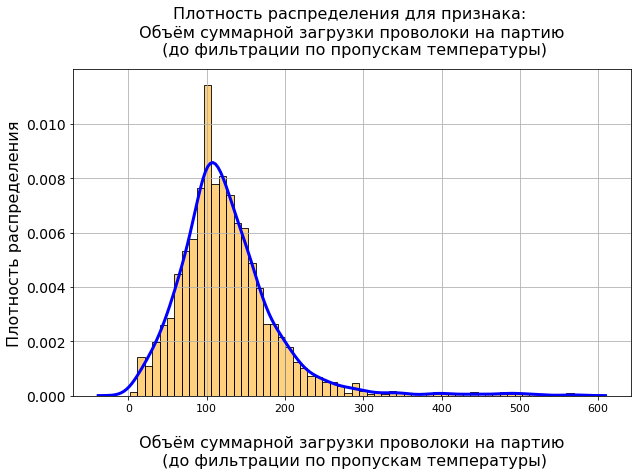

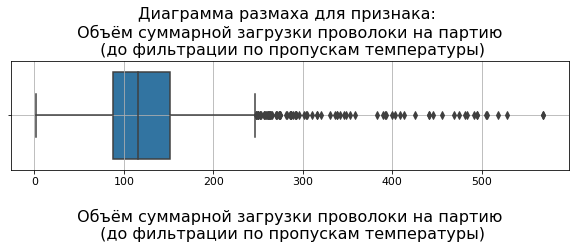

In [142]:
data_info(data_wire_full['volume_wire'], 
          '\n Объём суммарной загрузки проволоки на партию \n (до фильтрации по пропускам температуры)')

Есть одно выбивающееся значение по количеству суммарной загрузки проволоки: около **100**. Предпринимать пока что ничего не будем, чтобы не исказить результаты. Если точность модели будет неудовлитворительной, то будем вмешиваться.

Очевидно, что суммирование привело к увеличению разницы между средним 125.2 и медианой 116.1.

- **Добавляем новые признаки `'volume_wire'` и `'count_wire'` в сводный `df`**

Размерности, чтобы посмотреть сколько строк мы потеряем:

In [143]:
df.shape

(2397, 12)

In [144]:
data_wire_full.shape

(2371, 3)

Будем использовать тип слияния `inner`, так как количество партий в двух таблицах различается незначительно:

In [145]:
df = df.merge(data_wire_full,
              how='inner',
              on=['key'])

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2321 entries, 0 to 2320
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                2321 non-null   int64         
 1   min_time           2321 non-null   datetime64[ns]
 2   max_time           2321 non-null   datetime64[ns]
 3   temperature_first  2321 non-null   float64       
 4   temperature_last   2321 non-null   float64       
 5   temperature_mean   2321 non-null   float64       
 6   count_temp         2321 non-null   int64         
 7   inert_gas          2321 non-null   float64       
 8   electric_energy    2321 non-null   float64       
 9   count_heating      2321 non-null   int64         
 10  volume_bulk        2321 non-null   float64       
 11  count_bulk         2321 non-null   int64         
 12  volume_wire        2321 non-null   float64       
 13  count_wire         2321 non-null   int64         
dtypes: datet

По графику и характеристикам выборки видим, что существенных изменений после дополнительной фильтрации не появилось: 

 Характеристика выборки для признака:  
 Объём суммарной загрузки проволоки на партию


count    2321.000000
mean      125.108920
std        63.703990
min         1.918800
25%        88.845115
50%       116.017204
75%       151.364717
max       568.777664
Name: volume_wire, dtype: float64

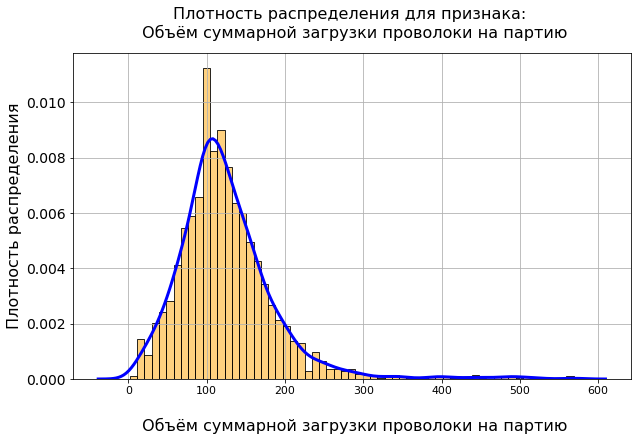

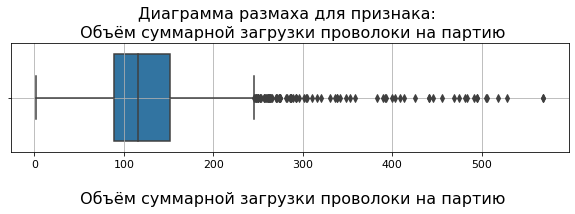

In [147]:
data_info(df['volume_wire'], '\n Объём суммарной загрузки проволоки на партию')

### Итоговый датафрейм для построения моделей

#### Признаки итогового датафрейма

Оставим в итоговом датафрейме только нужные для построения моделей признаки.

Удалим признаки, связанные со временем.

Размерность до удаления:

In [148]:
df.shape

(2321, 14)

Удаление столбцов `['key', 'min_time', 'max_time']` (они были нужны на стадии исследования и подготовки данных):

In [149]:
df = df.drop(['key', 'min_time', 'max_time'], axis=1)

Размерность после удаления

In [150]:
df.shape

(2321, 11)

- **Признаки итогового датафрейма:**

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2321 entries, 0 to 2320
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temperature_first  2321 non-null   float64
 1   temperature_last   2321 non-null   float64
 2   temperature_mean   2321 non-null   float64
 3   count_temp         2321 non-null   int64  
 4   inert_gas          2321 non-null   float64
 5   electric_energy    2321 non-null   float64
 6   count_heating      2321 non-null   int64  
 7   volume_bulk        2321 non-null   float64
 8   count_bulk         2321 non-null   int64  
 9   volume_wire        2321 non-null   float64
 10  count_wire         2321 non-null   int64  
dtypes: float64(7), int64(4)
memory usage: 217.6 KB


**Целевой признак:**

- **`temperature_last`** - температура последнего измерения температуры расплава стали

**Признаки:**

- `temperature_first` - температура начала нагрева
- `temperature_mean` - средняя температура в процессе нагрева (без учет целевого признака, но с учетом начальной, т.к. есть объекты, для которых известны только начальная и конечная температура нагрева)
- `count_temp` - количество измерений температуры в процессе нагрева (без учета целевого признака)
- `inert_gas` - расход инертного газа
- `electric_energy` - затраченная на нагрев электрическая энергия (активная мощность)
- `count_heating` - количество операций нагрева для каждой партии
- `volume_bulk` - загруженный в расплав объём сыпучих
- `count_bulk` - количество операций загрузки сыпучих
- `volume_wire` - загруженный в расплав объём проволоки
- `count_wire` - количество операций загрузки проволоки

#### Проверка мультиколлинеарности признаков

Проверим мультиколлинеарность выбранных признаков с помощью матрицы диаграмм рассеяния:

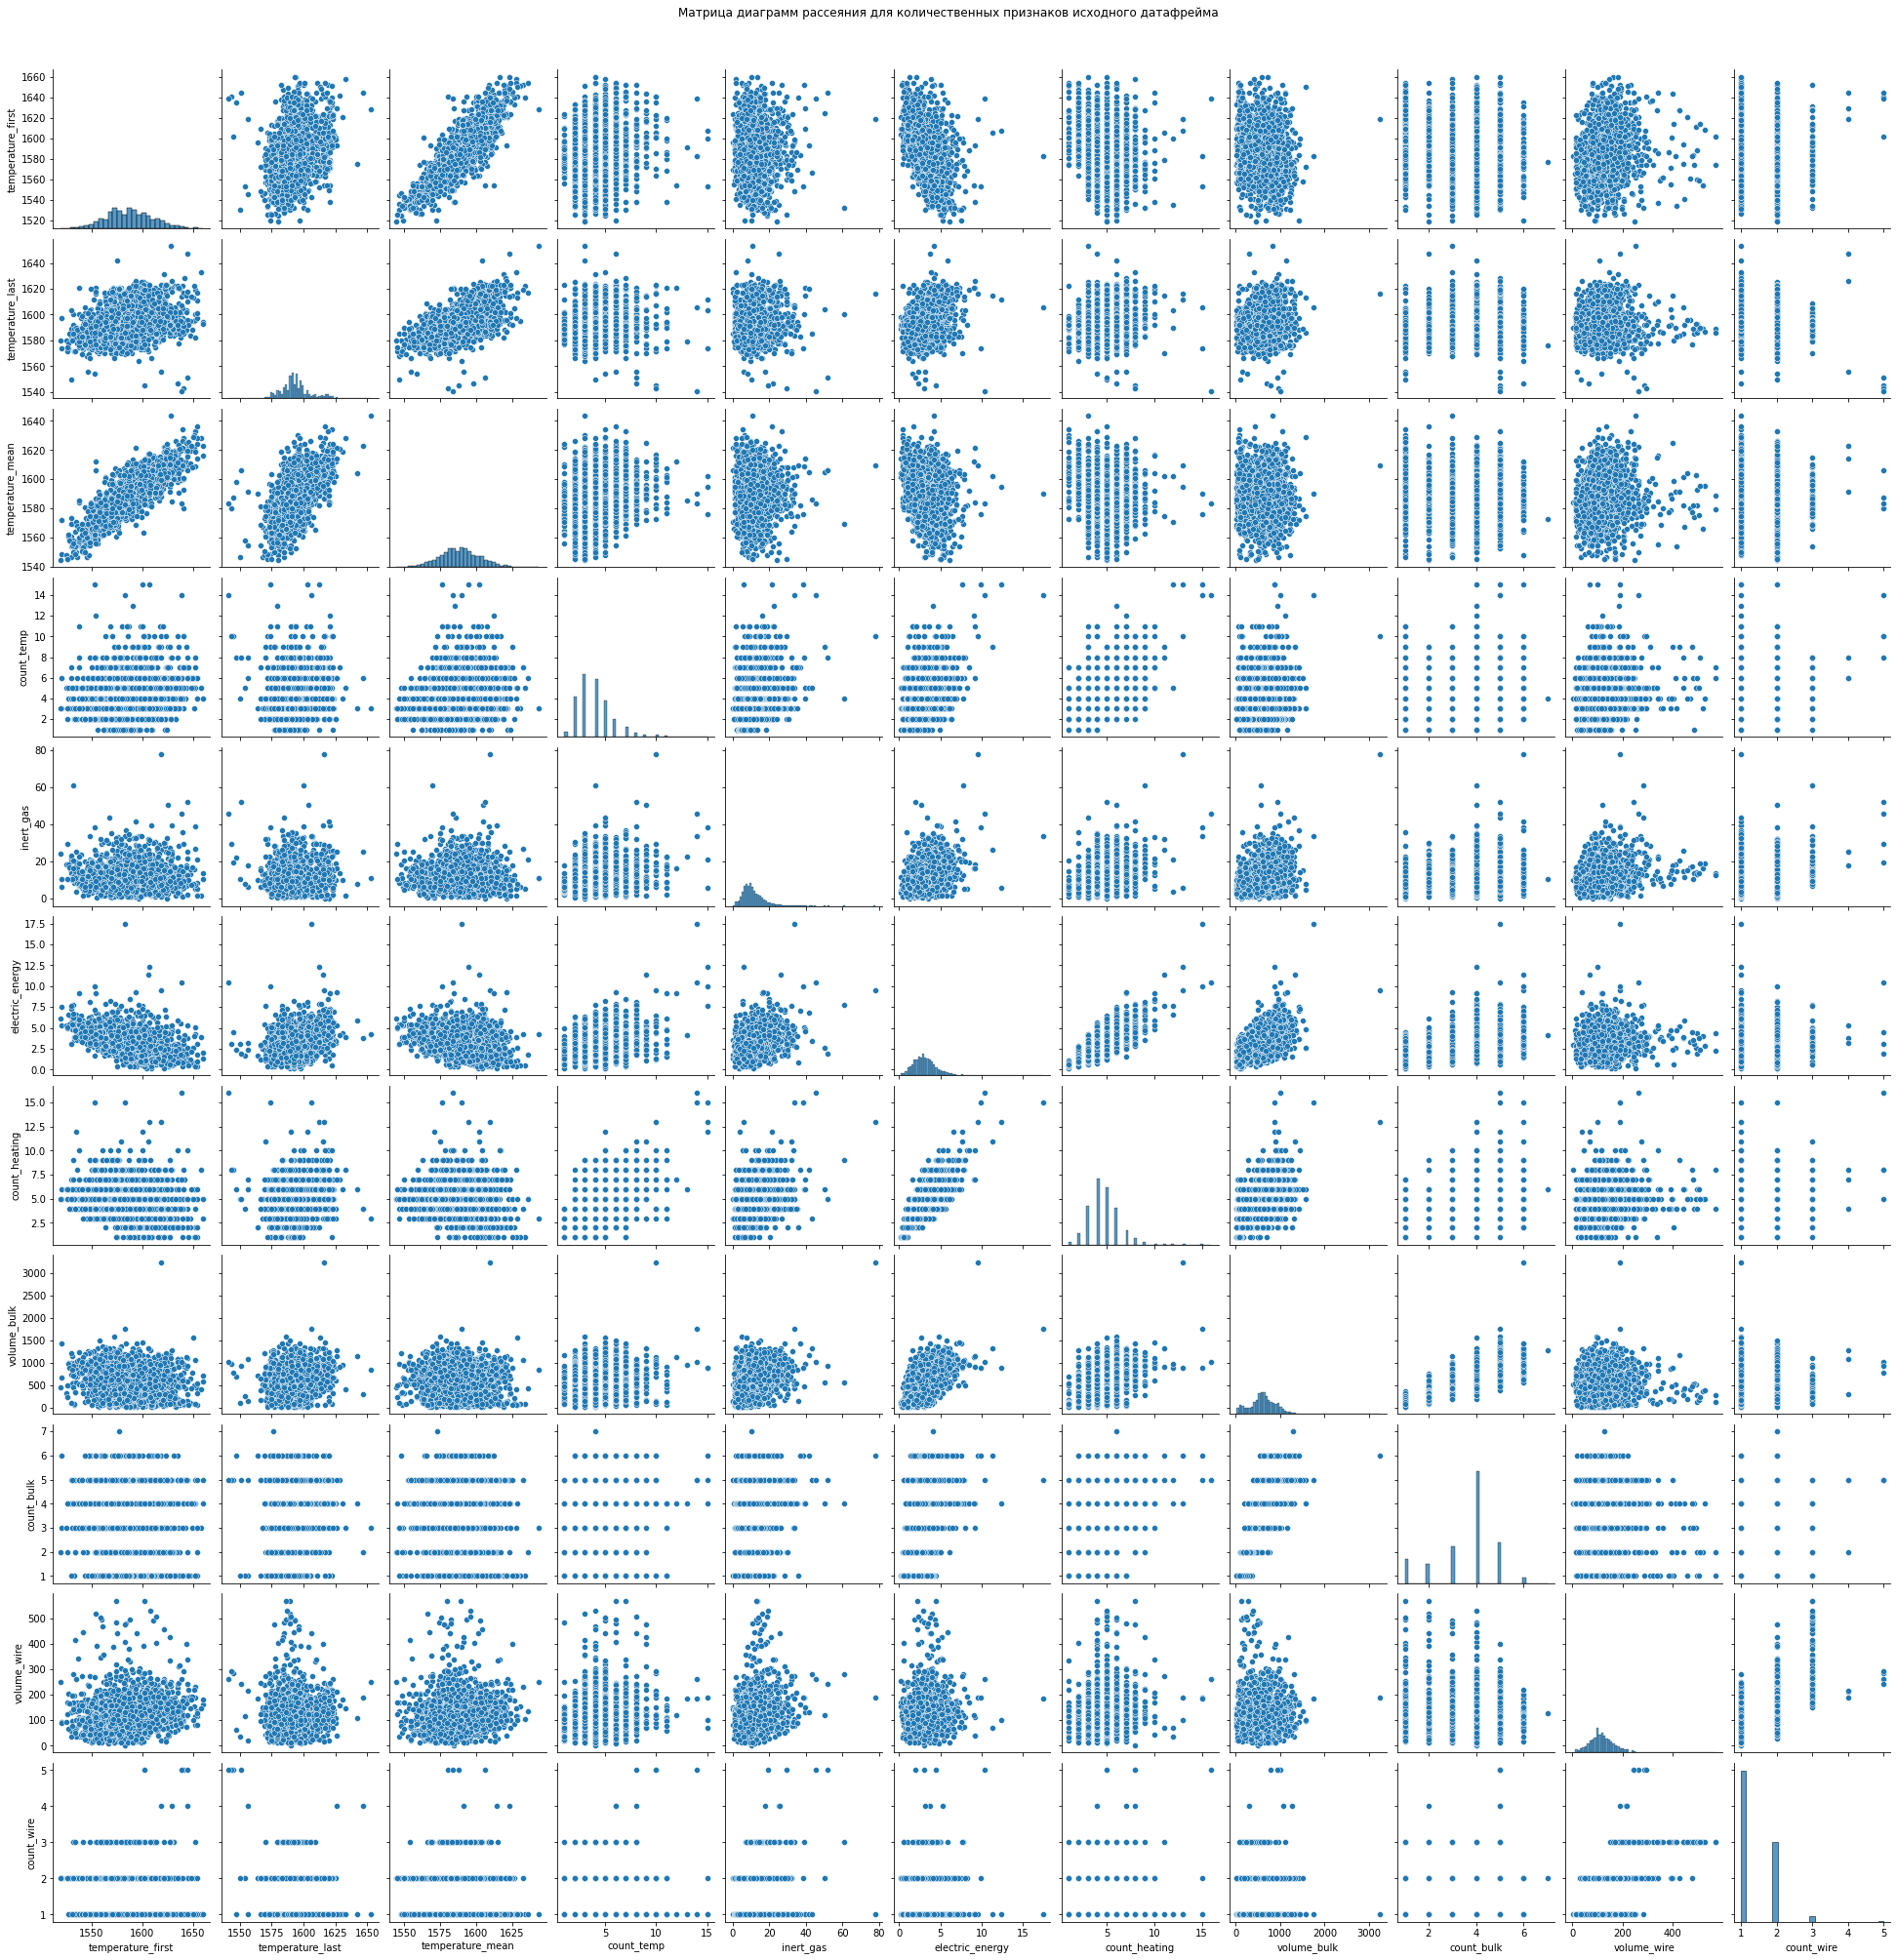

In [152]:
sns.pairplot(df).fig.suptitle("Матрица диаграмм рассеяния для количественных признаков исходного датафрейма", y=1.02)

plt.show()

Построим тепловую карту с коэффициентом корреляции Пирсона для всех признаков:

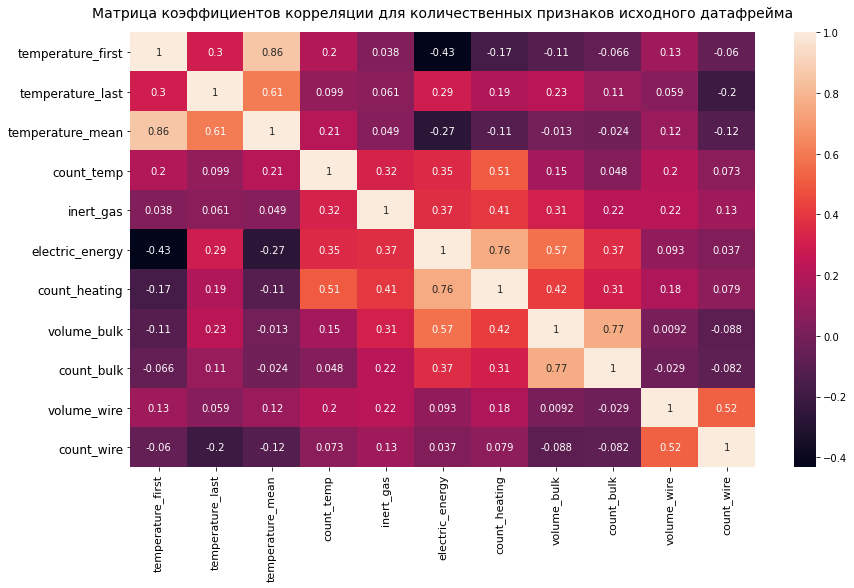

In [153]:
plt.figure(figsize=(14,8))

sns.heatmap(df.corr(),annot=True)

#название графика
plt.title('Матрица коэффициентов корреляции для количественных признаков исходного датафрейма', 
          fontsize=14, 
          loc='center',
          pad=15)

#задаём размер значений на оси абсцисс и на оси ординат
plt.xticks(fontsize=11)
plt.yticks(fontsize=12)

plt.show()

Очевидно, что некоторые признаки коррелируют между собой:

- Относительно сильная положительная зависимость между средней температурой нагрева и целевой метрикой (коэф. Пирсона около 0.61)

- Мы видим, что есть слабая отрицательная зависимость между электрической энергией и температурой начала нагрева. Отчасти это логично: **чем больше была начальная температура, тем меньше мы затратим энергии**. Возможно это также связано с тем, что мы учли энергию, затраченную до первого измерения.

- также присутствует средняя по величине положительная зависимость между объёмом сыпучих и электрической энергией. Логично, **чем больше добавили сыпучих, тем выше будут затраты энергии**.

- стоит отметить слабую положительную корреляцию между расходом газа и затратами электрической энергии, она тоже вполне логична: **чем больше инертного газа, тем выше затраты энергии**.

#### Уточнение признаков после проверки на мультиколлинеарность

Так как проверка ну мультиколлинеарность показала, что между целевым признаком и средней температурой наблюдается сильная положительная зависимость, то уберём её из рассмотрения. Это поможет модели **избежать "подсказок"** и выполнить свою бизнес-цель: предсказать конечную температуру процесса по исходной. Также уберём количество измерений, т.к. первичное моделирование показало их малую важность.

In [154]:
df = df.drop(['temperature_mean','count_temp','count_bulk','count_wire','count_heating'], axis=1)

### Вывод

Результаты исследовательского анализа данных и подготовки сводного датафрейма для дальнейшей работы:

1. **В дальнейшем** мы будем рассматривать только те `key` (номера партий), которые есть в таблице `data_temp`, так как нам нет смысла рассматривать партии, для которых нет целевого признака.

2. Из рассмотрения удалены партии с пропущенными значениями в целевом признаке, а также те, для которых была известна только 1 точка контроля температуры.

3. Распределение значений **температур начала нагрева** выглядит равномерным: среднее **1588,4** и медиана **1588** близки, маленькое значение стандартного отклонения (около 1,8% от среднего). Минимум 1191, максимум 1679. Всего 25% значений меньше 1572 градусов. Есть значения примерно на 400 градусов меньше, чем медиана и среднее. Используя статистический подход мы отбросили все значения начала нагрева **ниже 1450 град**. Будем иметь это в виду в дальнейшем. 

4. Распределение **температуры окончания нагрева** не так равномерно, но среднее 1595.3 и медиана 1593 близки, стандартное отклонение 16 меньше, чем в начале нагрева. Минимум 1541, максимум 1700. Оставим отфилтрованную выборку как есть. Это целевой признак, температура здесь - результат нескольких операций, которые нам предстоит учесть дальше.

5. **Расход инертного газа**. В среднем расход инертного газа в исходном наборе данных  11, медиана 9,8. Минимум - около 0. Максимум - около 80. Распределение несимметрично, немного скошено вправо. Удалять или отбрасывать никакие значения не будем, так как это результат технологического процесса.

6. В среднем за одну итерацию нагрева затрачивается около 0.67 (условных МВтч). Медиана около 0.50. Но нас будет интересовать сумма всех итераций нагрева.

7. Суммарные затраты электроэнергии (активной мощности) на партию распределены в выборке равномернее, чем для разового нагрева, так как медиана 3.11 и среднее 3.0 близки. Есть большие значения электроэнергии (свыше 7,5 условных МВтч), но пока что удалять их не будем. Если качество модели будет неудовлитворительное, то будем использовать это как потенциальную зона роста.

8. Распределение выборки **суммарной загрузки сыпучих для каждой партии**: медиана 604 и среднее 604,4 близки. Также обнаружено, что у гистограммы (и графика плотности) есть один явный пик в районе 700 и два менее явных: примерно около 100 и 1000.

9. Распределение выборки **суммарной загрузки проволоки для каждой партии**: есть одно выбивающееся значение по количеству суммарной загрузки проволоки - около 100. Удалять пока что не будем, чтобы не исказить результаты. Если точность модели будет неудовлитворительной, то будем вмешиваться. Очевидно, что суммирование привело к увеличению разницы между средним 125.2 и медианой 116.1. Минимум 1.91, максимум 568, 75% значений менее 151.

**В итоговый датафрейм вошёл 2321 объект и следующие признаки:**

**Целевой признак:**

- **`temperature_last`** - температура последнего измерения температуры расплава стали

**Признаки:**

- `temperature_first` - температура начала нагрева
- `inert_gas` - расход инертного газа
- `electric_energy` - затраченная на нагрев электрическая энергия (активная мощность)
- `volume_bulk` - загруженный в расплав объём сыпучих
- `volume_wire` - загруженный в расплав объём проволоки
   
Как будет показано далее некоторые признаки оказывают незначительное влияние на **важность признаков**. Но исключение их из рассмотрения приводило к снижению метрики. Поэтому было принято решение оставить приведенный набор признаков. Но далее будет дополнительно выполнена статистическая очистка от выбросов.

## **Обучение моделей**

###  Подготовка данных

#### Очистка данных от выборосов

Мы помним, что на стадии анализа данных обнаружили достаточно моного выбросов. Настал момент от них полностью избавиться, руководствуясь статистическим принципом и, частично, принципами бизнеса. Оставляем по *3IQR* "вниз" от *Q1* и "вверх" от *Q3* для каждого из признаков:

In [155]:
for name in df.columns:
    df = df[(df[name]>(df[name].quantile(0.25)-3*(df[name].quantile(0.75)-df[name].quantile(0.25))))&
            (df[name]<(df[name].quantile(0.75)+3*(df[name].quantile(0.75)-df[name].quantile(0.25))))]

In [156]:
df.describe()

temperature_first  temperature_last    inert_gas  electric_energy  \
count        2261.000000       2261.000000  2261.000000      2261.000000   
mean         1587.243255       1593.330827    11.100836         3.099209   
std            23.255166         10.622245     5.728987         1.327114   
min          1519.000000       1556.000000     0.008399         0.186226   
25%          1571.000000       1587.000000     7.240750         2.153840   
50%          1587.000000       1593.000000     9.997870         2.994277   
75%          1603.000000       1598.000000    14.009983         3.889616   
max          1660.000000       1628.000000    34.827057         8.429658   

       volume_bulk  volume_wire  
count  2261.000000  2261.000000  
mean    608.945157   120.375606  
std     278.607248    51.361982  
min      19.000000     1.918800  
25%     443.000000    88.077599  
50%     610.000000   115.140480  
75%     793.000000   150.132311  
max    1569.000000   338.722801

#### Разбивка данных на выборки

Разобъём исходную выборку на обучающую и тестовую в соотношении (4:1): 

|Выборка |Процент от количества объектов исходной выборки|
|:-----|:----:|
|Обучающая|80%|
|Тестовая|20%|

В данном проекте будем использовать кросс-валидацию. Поэтому на данном этапе отложим только тестовую выборку (20%), в обучающей оставим 80% исходного датасета (чтобы в дальнейшем выделять валидационную в процессе кросс-валидации).

Используем `train_test_split` из модуля `sklearn.model_selection`. Разбивку произведём псевдослучайным образом, задав параметр `random_state` равным `12345`.

In [157]:
# первый шаг разбивки - откладываем тестовую выборку, в обучающей оставляем 80%, 
#чтобы затем из неё выделять валидационную в процессе кросс-валидации
df_train, df_test = train_test_split(df, 
                                     test_size=0.20,
                                     random_state=12345) 

#### Тестовый и обучающий наборы данных

Сохраним обучающий и тестовый наборы данных в переменных `features` (признаки) и `target` (целевой признак).

Для этого создадим переменные для **признаков и целевого признака**. 

Сделаем это с использованием цикла по выборкам:

In [158]:
#цикл по названию выборки
for name in ['test','train']:
    
    #признаки для текущей выборки
    locals()['features_'+name] = (locals()['df_'+name]
                                  .drop(['temperature_last'], 
                                        axis=1))
    
    #вывод на экран именени переменной для таблицы признаков текущей выборки и её размерности
    print('features_'+name, 'shape:', 
          locals()['features_'+name].shape)
    
    #целевой признак для текущей выборки
    locals()['target_'+name] = (locals()['df_'+name]
                                ['temperature_last'])
    
    #вывод на экран названия переменной для целевого признака текущей выборки и его размерности
    print('target_'+name, 'shape:',
          locals()['target_'+name].shape)
    
    print()

features_test shape: (453, 5)
target_test shape: (453,)

features_train shape: (1808, 5)
target_train shape: (1808,)



Разбивка выполнена успешно, так как сходятся размерности новых датафреймов и исходного:

In [159]:
df.shape

(2261, 6)

In [160]:
features_train.shape[0]+features_test.shape[0]

2261

#### Масштабирование численных признаков

Как мы помним, все признаки датафрейма численные:

In [161]:
df.describe()

temperature_first  temperature_last    inert_gas  electric_energy  \
count        2261.000000       2261.000000  2261.000000      2261.000000   
mean         1587.243255       1593.330827    11.100836         3.099209   
std            23.255166         10.622245     5.728987         1.327114   
min          1519.000000       1556.000000     0.008399         0.186226   
25%          1571.000000       1587.000000     7.240750         2.153840   
50%          1587.000000       1593.000000     9.997870         2.994277   
75%          1603.000000       1598.000000    14.009983         3.889616   
max          1660.000000       1628.000000    34.827057         8.429658   

       volume_bulk  volume_wire  
count  2261.000000  2261.000000  
mean    608.945157   120.375606  
std     278.607248    51.361982  
min      19.000000     1.918800  
25%     443.000000    88.077599  
50%     610.000000   115.140480  
75%     793.000000   150.132311  
max    1569.000000   338.722801

Сохраним их в отдельную переменную:

In [162]:
numeric = features_train.columns

Выполним масштабирование численных признаков - приведём их к одному масштабу, чтобы модель не приняла какие-то отдельные признаки за более значимые.


Воспользуемся структурой библиотеки `sklearn` для *стандартизации данных* — **`StandardScaler`** (от англ. «преобразователь масштаба методом стандартизации»). Он находится в модуле `sklearn.preprocessing`.

Создадим объект этой структуры:

In [163]:
#создаём объект структуры StandardScaler
scaler = StandardScaler()

И настроим его на обучающих данных. Настройка — это вычисление среднего и дисперсии:

In [164]:
#настройка объекта на обучающих данных
scaler.fit(features_train[numeric]) 

StandardScaler()

Преобразуем обучающую, валидационную и тестовую выборки функцией `transform()`:

In [165]:
#преобразование обучающей выборки
features_train[numeric] = scaler.transform(features_train[numeric] )

#преобразование тестовой выборки
features_test[numeric]  = scaler.transform(features_test[numeric] ) 

Ознакомимся с результатом, выведем первые 5 строк численных признаков `features_train` после масштабирования:

In [166]:
features_train.head()

temperature_first  inert_gas  electric_energy  volume_bulk  volume_wire
466           -0.269096  -1.291645        -1.310724    -0.227420    -1.948181
112           -0.826990   1.843507         1.475817     0.877322    -1.209806
1824           0.889605  -0.377714        -0.948868    -0.574216     0.522390
707           -0.054522  -0.980495        -0.244720     0.401818     1.984137
261           -0.526585  -0.181907        -0.670754    -0.731525     0.221754

И ознакомимся с характеристиками выборки численных признаков после масштабирования:

In [167]:
#характеристики выборки численных признаков после масштабирования
features_train.describe()

temperature_first     inert_gas  electric_energy   volume_bulk  \
count       1.808000e+03  1.808000e+03     1.808000e+03  1.808000e+03   
mean        2.856122e-15 -5.108991e-17    -8.891609e-17 -1.375498e-16   
std         1.000277e+00  1.000277e+00     1.000277e+00  1.000277e+00   
min        -2.929819e+00 -1.959783e+00    -2.185155e+00 -2.104407e+00   
25%        -6.982450e-01 -6.810532e-01    -7.204023e-01 -5.956668e-01   
50%        -1.160696e-02 -1.891749e-01    -6.148023e-02  8.544526e-03   
75%         6.750311e-01  5.108003e-01     6.014436e-01  6.556584e-01   
max         3.121179e+00  4.203064e+00     3.836195e+00  3.437176e+00   

        volume_wire  
count  1.808000e+03  
mean  -1.532697e-16  
std    1.000277e+00  
min   -2.302114e+00  
25%   -6.263941e-01  
50%   -1.020921e-01  
75%    5.812621e-01  
max    4.245786e+00

Очевидно, что в результате масштабирования у численных признаков одинаковое стандартное отклонение.

### Модель линейной регрессии

Создадим модель линейной регрессии:

In [168]:
#зададим модель линейной регрессии
model_lr = LinearRegression()

С помощью кросс-валидации найдём значение `mean_squared_error`. Целевая метрика $MAE$. Параметр `cv` зададим равным 5:

In [169]:
scores_lr = cross_val_score(model_lr, 
                            features_train, 
                            target_train,
                            scoring='neg_mean_absolute_error',
                            cv=5)

Выведем массив результатов MAE:

In [170]:
np.array(scores_lr)

array([-6.40693343, -6.46462133, -6.37250875, -6.5501785 , -6.41497477])

Найдём среднее значение:

In [171]:
np.mean((scores_lr*(-1)))

6.441843355752249

**Обучим модель** на полном наборе *тренировочных данных* (и сохраним время обучения):

In [172]:
%%time
start_time = time.time()

model_lr.fit(features_train,target_train)

elapsed_time_fit_lr = (time.time() - start_time)*1000

CPU times: user 2.66 ms, sys: 0 ns, total: 2.66 ms
Wall time: 2.4 ms


Вычислим MAE для тренировочной выборки:

In [173]:
mae_train_lr= mean_absolute_error(target_train, 
                                  model_lr.predict(features_train))

mae_train_lr

6.402485299145346

В проекте желательно достигнуть метрики MAE<6. В данном случае результат для такой простой модели как линейная регрессия хороший.

Попробуем другие модели, к линейной регрессии вернёмся позднее, чтобы проверить качество на тестовой выборке.

### Модель решающего дерева

Создадим модель решающего дерева:

In [174]:
model_dtr = DecisionTreeRegressor(random_state=12345)

Будем варьировать максимальную глубину дерева в процессе подбора гиперпараметров:

In [175]:
grid_parameters_dtr = {'max_depth': [1,2,3,4,5,6,7,8,9,10]} 

Подбор гиперпараметров выполним с помощью `GridSearchCV`:
- в качестве оценки качества будем использовать `'neg_mean_absolute_error'`, 
- количество *фолдов* зададим равным `6` (определено в процессе).

Приступаем:

In [176]:
grid_search_dtr = GridSearchCV(model_dtr,
                               grid_parameters_dtr,
                               scoring='neg_mean_absolute_error',
                               cv=6,
                               verbose=False)

Запускаем процесс автоматизированного подбора гиперпараметров:

In [177]:
%%time
grid_search_dtr.fit(features_train,target_train)

CPU times: user 403 ms, sys: 0 ns, total: 403 ms
Wall time: 405 ms


GridSearchCV(cv=6, estimator=DecisionTreeRegressor(random_state=12345),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='neg_mean_absolute_error', verbose=False)

Выводим параметры лучшей модели:

In [178]:
grid_search_dtr.best_params_

{'max_depth': 4}

Сохраним лучшую модель решающего дерева:

In [179]:
best_model_dtr = DecisionTreeRegressor(max_depth=grid_search_dtr.best_params_['max_depth'], 
                                       random_state=12345)

Обучим на полном наборе тренировочных данных:

In [180]:
%%time

start_time = time.time()

best_model_dtr.fit(features_train,target_train)

elapsed_time_fit_dtr = (time.time() - start_time)*1000

CPU times: user 4.99 ms, sys: 64 µs, total: 5.05 ms
Wall time: 4.82 ms


Найдём MAE на обучающей выборке:

In [181]:
mae_train_dtr= mean_absolute_error(target_train, 
                                   best_model_dtr.predict(features_train))

mae_train_dtr

6.438321174422351

Для обучающей выборки результат неплохой. Далее посмотрим как поведут себя другие модели, к решающему дереву вернёмся в конце на стадии тестирования.

### Модель случайного леса

Создадим модель случайного леса

In [182]:
model_rfr = RandomForestRegressor(random_state=12345)

*Максимальная глубина* решающего дерева и *количество деревьев* - гиперпараметры, которые будем варьировать для подбора наилучшей модели:

In [183]:
grid_parameters_rfr = {'max_depth': [6,7,8,9,10,11,12],          
                       'n_estimators':[260,300,325,350,375]} 

Подбор гиперпараметров выполним, как и на предыдущем шаге, с помощью `GridSearchCV`, метрика качества сохраняется:

In [184]:
grid_search_rfr = GridSearchCV(model_rfr,
                               grid_parameters_rfr,
                               scoring='neg_mean_absolute_error',
                               cv=6,
                               verbose=False)

Приступаем к подбору:

In [185]:
%%time
grid_search_rfr.fit(features_train,target_train)

CPU times: user 4min 17s, sys: 1.45 s, total: 4min 18s
Wall time: 4min 18s


GridSearchCV(cv=6, estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': [6, 7, 8, 9, 10, 11, 12],
                         'n_estimators': [260, 300, 325, 350, 375]},
             scoring='neg_mean_absolute_error', verbose=False)

Выводим лучшие параметры:

In [186]:
grid_search_rfr.best_params_

{'max_depth': 8, 'n_estimators': 260}

Сохраняем лучшую модель случайного леса:

In [187]:
best_model_rfr = RandomForestRegressor(max_depth=grid_search_rfr.best_params_['max_depth'], 
                                       n_estimators=grid_search_rfr.best_params_['n_estimators'],
                                       random_state=12345)

Выполняем обучение на полном тренировочном наборе данных:

In [188]:
%%time

start_time = time.time()

best_model_rfr.fit(features_train,target_train)

elapsed_time_fit_rfr = (time.time() - start_time)*1000

CPU times: user 1.04 s, sys: 4.03 ms, total: 1.05 s
Wall time: 1.05 s


Смотрим целевую метрику на обучающем наборе:

In [189]:
mae_train_rfr = mean_absolute_error(target_train, 
                                    best_model_rfr.predict(features_train))

mae_train_rfr

4.462276599292832

Отметим, что это **очень хороший результат**. Посмотрим, что будет на "тесте". А сейчас перейдём к ещё более сложной, но интересной модели: градиентный бустинг для задач регрессии.

### Модель градиентного бустинга

Так как для `CatBoost` не требуется масштабирование численных признаков, то выполним разбивку повторно

In [190]:
#цикл по названию выборки
for name in ['test','train']:
    
    #признаки для текущей выборки
    locals()['X_'+name] = (locals()['df_'+name]
                                  .drop(['temperature_last'], 
                                        axis=1))
    
    #вывод на экран именени переменной для таблицы признаков текущей выборки и её размерности
    print('X_'+name, 'shape:', 
          locals()['X_'+name].shape)
    
    #целевой признак для текущей выборки
    locals()['y_'+name] = (locals()['df_'+name]
                                ['temperature_last'])
    
    #вывод на экран названия переменной для целевого признака текущей выборки и его размерности
    print('y_'+name, 'shape:',
          locals()['y_'+name].shape)
    
    print()

X_test shape: (453, 5)
y_test shape: (453,)

X_train shape: (1808, 5)
y_train shape: (1808,)



Создадим модель градиентного бустинга. Для выбора лучшей модели будем использовать функцию потерь **`MAE`**.

In [191]:
model_cbr = CatBoostRegressor(loss_function='MAE',
                              random_state=12345,
                              verbose=100)

Введём гиперпараметры, которые будем изменять:

- `max_depth` - максимальная глубина дерева,
- `n_estimators` - количество итераций (максимальное количество деревьев, которое можно построить при решении задач машинного обучения),
- `learning_rate` - скорость обучения.

In [192]:
grid_parameters_cbr = {'max_depth': [5,6,7,8],                  #Depth of the tree.
                        'n_estimators':[200,250,300],     #The maximum number of trees that can be 
                                                                  #built when solving machine learning problems.
                        'learning_rate':[0.03,0.04,0.05,0.1]}  #The learning rate. Used for reducing the gradient step

Воспользуемся `GridSearchCV` для подбора оптимальных параметров (количество *фолдов* 7 определено в процессе нескольких итераций):

In [193]:
grid_search_cbr = GridSearchCV(model_cbr,
                               grid_parameters_cbr,
                               cv=7,
                               verbose=False)

Выполним поиск оптимальных гиперпараметров:

In [194]:
%%time
grid_search_cbr.fit(X_train,y_train)

0:	learn: 7.6811675	total: 48.9ms	remaining: 9.74s
100:	learn: 5.9401595	total: 139ms	remaining: 136ms
199:	learn: 5.5287028	total: 231ms	remaining: 0us
0:	learn: 7.6516452	total: 1.01ms	remaining: 201ms
100:	learn: 6.0279468	total: 92.5ms	remaining: 90.7ms
199:	learn: 5.6197366	total: 191ms	remaining: 0us
0:	learn: 7.7468571	total: 916us	remaining: 182ms
100:	learn: 6.0019620	total: 100ms	remaining: 98.4ms
199:	learn: 5.5626946	total: 193ms	remaining: 0us
0:	learn: 7.7059022	total: 1.09ms	remaining: 216ms
100:	learn: 5.9479084	total: 96.1ms	remaining: 94.2ms
199:	learn: 5.5346924	total: 185ms	remaining: 0us
0:	learn: 7.7663667	total: 1.09ms	remaining: 217ms
100:	learn: 5.9934352	total: 94.5ms	remaining: 92.7ms
199:	learn: 5.5534955	total: 193ms	remaining: 0us
0:	learn: 7.7567667	total: 1.1ms	remaining: 219ms
100:	learn: 5.9820514	total: 99.8ms	remaining: 97.9ms
199:	learn: 5.5492883	total: 198ms	remaining: 0us
0:	learn: 7.8000313	total: 1.04ms	remaining: 208ms
100:	learn: 5.9928772	to

GridSearchCV(cv=7,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f043f7664c0>,
             param_grid={'learning_rate': [0.03, 0.04, 0.05, 0.1],
                         'max_depth': [5, 6, 7, 8],
                         'n_estimators': [200, 250, 300]},
             verbose=False)

Выведем лучшие обнаруженные параметры:

In [195]:
grid_search_cbr.best_params_

{'learning_rate': 0.04, 'max_depth': 7, 'n_estimators': 250}

Сохраним соответствующую лучшую модель:

In [196]:
best_model_cbr = CatBoostRegressor(learning_rate=grid_search_cbr.best_params_['learning_rate'], 
                                   max_depth=grid_search_cbr.best_params_['max_depth'], 
                                   n_estimators=grid_search_cbr.best_params_['n_estimators'],
                                   random_state=12345,
                                   verbose=100)

Обучим лучшую модель на полном наборе данных и посмотрим ключевую метрику:

In [197]:
start_time = time.time()

best_model_cbr.fit(X_train,y_train)

elapsed_time_fit_cbr = (time.time() - start_time)*1000

0:	learn: 10.4990791	total: 2.58ms	remaining: 643ms
100:	learn: 7.4428408	total: 222ms	remaining: 328ms
200:	learn: 6.8130600	total: 432ms	remaining: 105ms
249:	learn: 6.5663828	total: 532ms	remaining: 0us


MAE для обучающего набора данных.

In [198]:
mae_train_cbr = mean_absolute_error(y_train, 
                                    best_model_cbr.predict(X_train))

mae_train_cbr

5.0597052846374995

И перейдём к тестированию.

### Вывод

В ходе обучения моделей рассмотрены:
- линейная регрессия,
- решающее дерево,
- случайный лес,
- `CatBoost` для задач регрессии.

А также:
- Перед обучением модели была выполнена очистка признаков от выбросов, опираясь на статистический подход. Границы доверительного интервала выбраны *3IQR от Q1 вниз и от Q3 вверх*
- Для первых трех моделей выполнено масштабирование признаков.
- Для всех моделей (кроме линейной регрессии) выполнен подбор гипперпараметров с помощью `GridSearchVC`.
- На обучающей выборке наиболее перспективные результаты у `CatBoost`.

## **Тестирование моделей**

Переходим к проверке лучших моделей на тестовом наборе данных.

### Линейная регрессия

Сохраним предсказания и время, за которое модель выдаёт массив предсказаний:

In [199]:
%%time

start_time = time.time()

predicted_values_lr = model_lr.predict(features_test)

elapsed_time_pred_lr = (time.time() - start_time)*1000

CPU times: user 1.59 ms, sys: 43 µs, total: 1.63 ms
Wall time: 1.62 ms


Вычислим MAE для линейной регрессии на тестовом наборе данных, обученной на полном наборе тренировочных данных:

In [200]:
mae_lr = mean_absolute_error(target_test, 
                             predicted_values_lr)

mae_lr

6.3807995038667515

Для такой простой модели как линейная регрессия это очень неплохой результат, но другие модели, вероятно, должны быть ещё лучше.

### Решающее дерево

Переходим к проверке лучше модели решающего дерева. Мы обучили её на полном наборе тренировочных данных ранее.

Сразу переходим к предсказаниям (и сохраняем время):

In [201]:
%%time

#делаем предсказания на тестовой выборке

start_time = time.time()

predicted_values_dtr = best_model_dtr.predict(features_test)

elapsed_time_pred_dtr = (time.time() - start_time)*1000

CPU times: user 1.96 ms, sys: 0 ns, total: 1.96 ms
Wall time: 1.91 ms


Вычисляем целевую метрику на тестовом наборе данных:

In [202]:
mae_dtr = mean_absolute_error(target_test, 
                              predicted_values_dtr)

mae_dtr

6.877340208380754

Результат хуже, чем у линейной регрессии. Решающее дерево - склонно к переобучению.

### Случайный лес

Используем предварительно обученную на полном наборе данных лучшую модель случайного леса: предсказываем на тестовой выборке. 

In [203]:
%%time


start_time = time.time()

#делаем предсказания на тестовой выборке
predicted_values_rfr = best_model_rfr.predict(features_test)

elapsed_time_pred_rfr = (time.time() - start_time)*1000

CPU times: user 31.8 ms, sys: 0 ns, total: 31.8 ms
Wall time: 31.1 ms


Вычисляем целевую метрику на тестовом наборе данных.

In [204]:
mae_rfr = mean_absolute_error(target_test, 
                              predicted_values_rfr)

mae_rfr

6.162101258462051

Ансамбль моделей превзошёл линейную регрессию, хороший результат.

### Градиентный бустинг

Самое важное для внедрения модели (точнее один из самых важных критериев) - время предсказания, как и прежде будем его учитывать, когда находим предсказания лучшей модели градиентного бустинга:

In [205]:
%%time

#делаем предсказания на тестовой выборке

start_time = time.time()

predicted_values_cbr = best_model_cbr.predict(X_test)

elapsed_time_pred_cbr = (time.time() - start_time)*1000

CPU times: user 0 ns, sys: 1.78 ms, total: 1.78 ms
Wall time: 1.4 ms


Вычислим $MAE$ на тестовой выборке для модели градиентного бустинга, обученной на полном наборе тренировочных данных:

In [206]:
mae_cbr = mean_absolute_error(y_test, 
                              predicted_values_cbr)

mae_cbr

6.0747543114839555

Лучший результат - градиентный бустинг.

### Сводные результаты

Сводные результаты отобразим в виде таблицы:

In [207]:
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

pd.DataFrame({'Модель': ['Линейная регрессия (lr)', 
                         'Решающее дерево (dtr)',
                         'Случайный лес (rfr)',
                         'CatBoostRegressor (cbr)'],
              'Лучшие гиперпараметры':['-',
                                       grid_search_dtr.best_params_,
                                       grid_search_rfr.best_params_,
                                       grid_search_cbr.best_params_],
              'MAE - train':[mae_train_lr, 
                             mae_train_dtr, 
                             mae_train_rfr,
                             mae_train_cbr],
              'MAE - test':[mae_lr, 
                            mae_dtr, 
                            mae_rfr,
                            mae_cbr],
              'Время обучения (на полном наборе), мс':[elapsed_time_fit_lr, 
                                                       elapsed_time_fit_dtr,
                                                       elapsed_time_fit_rfr,
                                                       elapsed_time_fit_cbr],
              'Время предсказания (на тестовом), мс':[elapsed_time_pred_lr,
                                                      elapsed_time_pred_dtr,
                                                      elapsed_time_pred_rfr,
                                                      elapsed_time_pred_cbr]
             })


Модель  \
0  Линейная регрессия (lr)   
1    Решающее дерево (dtr)   
2      Случайный лес (rfr)   
3  CatBoostRegressor (cbr)   

                                          Лучшие гиперпараметры  MAE - train  \
0                                                             -     6.402485   
1                                              {'max_depth': 4}     6.438321   
2                         {'max_depth': 8, 'n_estimators': 260}     4.462277   
3  {'learning_rate': 0.04, 'max_depth': 7, 'n_estimators': 250}     5.059705   

   MAE - test  Время обучения (на полном наборе), мс  \
0    6.380800                               2.379417   
1    6.877340                               4.798651   
2    6.162101                            1045.781612   
3    6.074754                             908.318520   

   Время предсказания (на тестовом), мс  
0                              1.584768  
1                              1.893282  
2                             31.068563  
3                              1.379251

Из сводной таблицы видно, что лучший результат на тестовой выборке позволила получить модель `CatBoostRegressor`, как по целевой метрике MAE, так и по времени предсказаний (в миллисекундах).

### График - предсказания и ответы для лучшей модели

**Для иллюстрации результатов работы модели** отобразим на одном графике 15 предсказаний и 15 ответов:

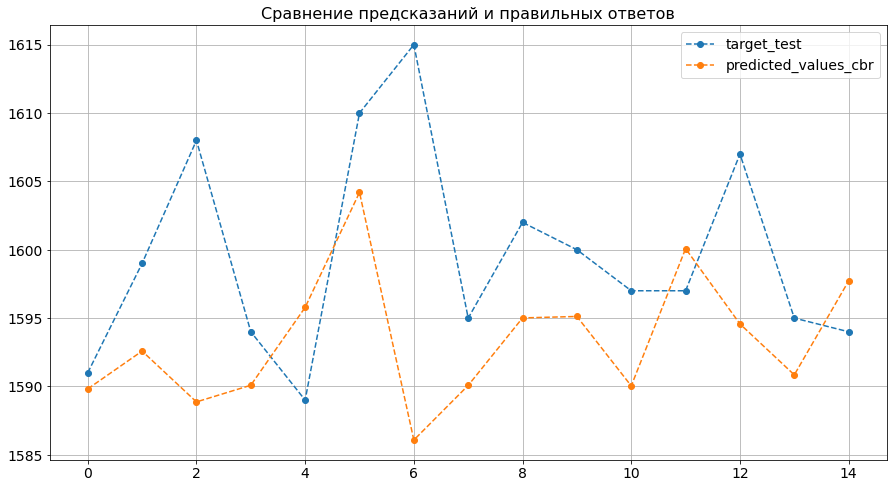

In [208]:
#размер графика
plt.figure(figsize=(15,8))

#строим график
plt.plot(target_test.reset_index(drop=True)[0:15].index,
         target_test.reset_index(drop=True)[0:15],
             '--o',
             label='target_test')

plt.plot(target_test.reset_index(drop=True)[0:15].index,
         pd.Series(predicted_values_cbr).reset_index(drop=True)[0:15],
         '--o',
         label='predicted_values_cbr')

#название графика
plt.title('Сравнение предсказаний и правильных ответов',
          fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#отображение сетки
plt.grid()
plt.legend(fontsize=14)
plt.show()

Очевидно, что соответствие предсказаний и ответов присутствует на довольно хорошем уровне, в пределах погрешности. Как было отмечено выше, целевая метрика достигнута.

В приведенном масштабе ошибка может показаться существенной, но это не так. Даже для первых 15 значений максимально достигает 30 градусов (точка с номером 6). Это около 1,9% от праильной температуры. Это довольно высокий уровень точности, учитывая, что предсказания выполняются без физического "движка".

### Важность признаков для лучшей модели

Проанализируем важность признаков для лучшей модели:

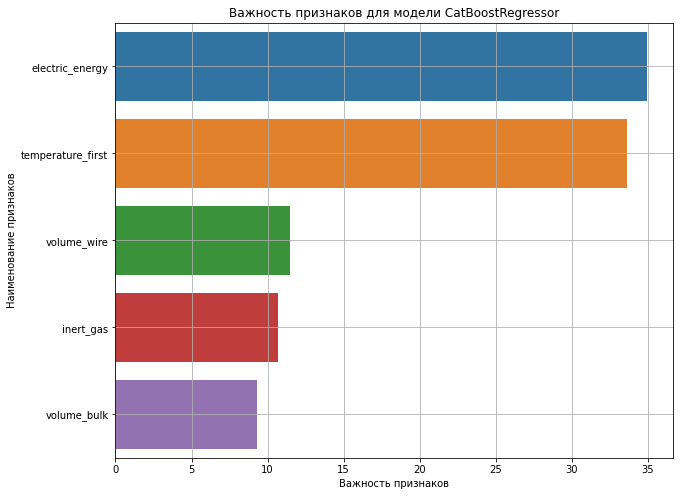

In [209]:
feature_importance = np.array(best_model_cbr.get_feature_importance())
feature_names = np.array(X_train.columns)
data_for_fi={'feature_names':feature_names,'feature_importance':feature_importance}
fi_df = pd.DataFrame(data_for_fi)
fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

plt.figure(figsize=(10,8))
sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

plt.title("Важность признаков для модели " + 'CatBoostRegressor')
plt.xlabel('Важность признаков')
plt.ylabel('Наименование признаков')

plt.grid()
plt.show()

**Результат для 9 признаков:** выглядил следующим образом. По причине низкой важности количество различных операций было исключено из рассмотрения, чтобы не усложнять модель.

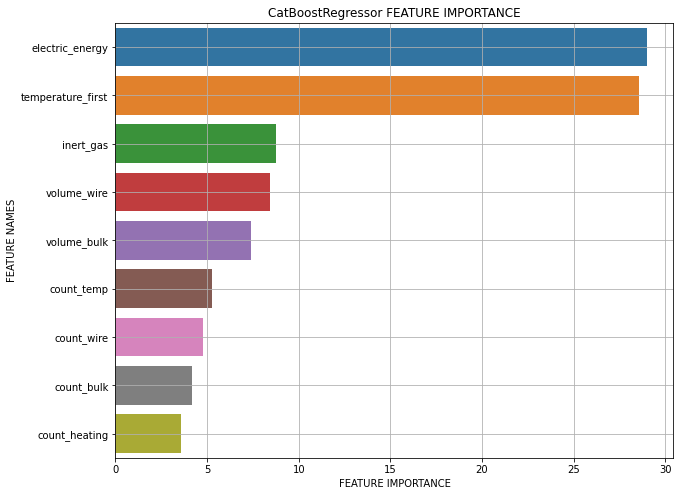

Из анализа важности признаков можно сделать следующие выводы:

- Наибольший уровень важности - затраченная электрическая энергия. Затраченная электрическая энергия -  это последствие добавленных сыпучих, проволоки и инертного газа, а также точки, с которой начинается нагрев - начальной температуры. Напомни, что задача бизнеса - сократить расход электрической энергии.

- Второй по важности признак - начальная температура. Логично, ведь конечная зависит от начальной и затраченной электрической энергии.

- Третий по важности признак - расход инертного газа. Приводит к потерям тепловой энергии. Об этом мы говорили выше.

- Далее по уровню важности: объём проволоки, объём сыпучих, 

- Затем идёт количество операций: измерений температуры, добавлений проволоки, сыпучих и количество операций нагерва. количество измерений температур, это также объяснимо, ведь корректировка состава приводит к повторному измерению.

### Вывод

Краткие результаты тестирования моделей:
- Лучшие результаты получились у CatBoostRegressor.
- В тройку важности признаков вошли: затраченная электрическая энергия, начальная температура и расход инертного газа.

___

## **Отчёт по решению поставленной задачи**

Перед нами была поставлена **задача**: *построить модель, которая предскажет температуру стали*. Решение поможет Заказчику - Металлургическому комбинату *ООО «Так закаляем сталь»* - оптимизировать производственные расходы путём уменьшения потребления электроэнергии на этапе обработки стали.

### Описание исходных данных

**Исходные данные были представлены в 7-ми таблицах**:
    
- **Целевой признак** - *температура стали* - представлен в таблице **`data_temp`**, в которой для каждой партии по ключу `key` произведено несколько замеров. 


- В таблице **`data_arc`** содержатся данные об электродах:
    - *Признаки*: начало нагрева, конец нагрева, активная и реактивная мощности.  
    - Стоит отметить, что мощность - это мнгновенная характеристика (измеряется в Вт, то есть в Дж/с). На переговорах рабочей группы было внесено уточнение, что *активную мощность* следует считать **энергией**, затраченной за приведённый период времени , которая, будем полагать, измеряется, например, в МВтч (условно). 
    - **Реактивную мощность** было решено не учитывать, так как по факту это **потери**.
    - Для каждой партии было несколько циклов нагрева. Учтены все, но с предварительной фильтрацией по времени: *не учитывалась энергия, затраченная после последнего измерения температуры*. 
    - Энергия (активная мощность), затраченная до первого измерения температуры, учтена.


- Не менее важная таблица **`data_gas`** - расход инертного газа для каждой партии. Расход рассматривался как суммарный, затраченный на каждую партию. Расход инертного газа важен, потому что он влияет на температуру расплава.


- В таблицах **`data_bulk`, `data_bulk_time`, `data_wire` и `data_wire_time`** много пропущенных значений.  


- Время подачи **`data_bulk_time` и `data_wire_time`** использовались для исключения добавок, введённых в расплав после последнего измерения температуры. Добавки введеные до первого измерения учтены в общей сумме, так как они оказывают влияние на первую температуру.

### Результаты исследовательского анализа данных

- В итоговый датафрейм включены только те `key` (номера партий), которые есть в таблице `data_temp`, так как мы не можем рассматривать объекты без целевого признака. По этой же причине удалены партии с пропущенными значениями в целевом признаке, а также те, для которых была известна только 1 точка контроля температуры.

- Распределение значений **температур начала нагрева** выглядит равномерным: среднее **1588,4** и медиана **1588** близки, маленькое значение стандартного отклонения (около 1,8% от среднего). Минимум 1191, максимум 1679. Всего 25% значений меньше 1572 градусов. Есть значения примерно на 400 градусов меньше, чем медиана и среднее. Используя статистический подход мы отбросили все значения начала нагрева **ниже 1450 град**.

- Распределение **температуры окончания нагрева** не так равномерно, но среднее 1595.3 и медиана 1593 близки, стандартное отклонение 16 меньше, чем в начале нагрева. Минимум 1541, максимум 1700. Оставим отфилтрованную выборку как есть. Это целевой признак, температура здесь - результат нескольких операций, которые нам предстоит учесть дальше.

- **Расход инертного газа**. В среднем расход инертного газа в исходном наборе данных  11, медиана 9,8. Минимум - около 0. Максимум - около 80. Распределение несимметрично, немного скошено вправо. Удалять или отбрасывать никакие значения не будем, так как это результат технологического процесса.

- В среднем за одну итерацию нагрева затрачивается около 0.67 (условных МВтч). Медиана около 0.50. Но нас будет интересовать сумма всех итераций нагрева.

- Суммарные затраты электроэнергии (активной мощности) на партию распределены в выборке равномернее, чем для разового нагрева, так как медиана 3.11 и среднее 3.0 близки. Есть большие значения электроэнергии (свыше 7,5 условных МВтч).

- Распределение выборки **суммарной загрузки сыпучих для каждой партии**: медиана 604 и среднее 604,4 близки. Также обнаружено, что у гистограммы (и графика плотности) есть один явный пик в районе 700 и два менее явных: примерно около 100 и 1000.

- Распределение выборки **суммарной загрузки проволоки для каждой партии**: есть одно выбивающееся значение по количеству суммарной загрузки проволоки - около 100. Суммирование по партии привело к увеличению разницы между средним 125.2 и медианой 116.1. Минимум 1.91, максимум 568, 75% значений менее 151.

### Признаки итогового датафрейма для моделирования

В ходе проверки признаков на мультиколлинеарность было обнаружено:

- Относительно сильная положительная зависимость между средней температурой нагрева и целевой метрикой (коэф. Пирсона около 0.61)


- Слабая отрицательная зависимость между электрической энергией и температурой начала нагрева. Отчасти это логично: **чем больше была начальная температура, тем меньше мы затратим энергии**. Возможно это также связано с тем, что мы учли энергию, затраченную до первого измерения.


- Также присутствует средняя по величине положительная зависимость между объёмом сыпучих и электрической энергией, то есть **чем больше добавили сыпучих, тем выше будут затраты энергии**.


- Стоит отметить слабую положительную корреляцию между расходом газа и затратами электрической энергии, она тоже вполне логична, так как **чем больше инертного газа, тем выше затраты энергии**.


После проверки признаков на мультиколлинеарность было принято окончательное решение о признаках, вошедших в итоговый даатфрейм.


**В итоговый датафрейм вошёл 2321 объект и следующие признаки:**


**Целевой признак:**


- **`temperature_last`** - температура последнего измерения температуры расплава стали


**Признаки:**


- `temperature_first` - температура начала нагрева
- `inert_gas` - расход инертного газа
- `electric_energy` - затраченная на нагрев электрическая энергия (активная мощность)
- `volume_bulk` - загруженный в расплав суммарный объём сыпучих
- `volume_wire` - загруженный в расплав суммарный объём проволоки

### Отклонения от намеченного плана работ и сложности проекта

- После первичного знакомства с данными и исследовательского анализа данных был подготовлен примерный план выполнения проекта.


- Изначально планировалось применять `train_test_split` для получения тестовой, тренировочной и валидационной выборок. Но по ходу выполнения проекта было принято решение использовать эту команду только для обучающей и тестовой, так как валидационная формировалась на стадии кросс-валидации с помощью `GridSearchCV`. 


- Вместо соотношения 3:1:1 было зафиксировано начальное соотношение между обучением и тестом: **4:1**. Соотношение между обучением и валидацией варьировалось в ходе определения варианта с лучшим значением  на тестовой выборке: путём изменения параметра `cv`.


- Первоначально при `cv=5` для модели `CatBoostRegressor` на пяти признаках (энергия, температура начальная, инертный газ, объём сыпучих, объём проволоки) была достигнута ключевая метрика $\mathbf{MAE}$ равная $\mathbf{6.11456}$ для модели с гиперпараметрами `{'learning_rate': 0.04, 'max_depth': 8, 'n_estimators': 400}`.


- После этого была предпринята попытка улучшить метрику путём изменения `cv` в диапазоне от 3 до 10. Было рассмотрено 7 вариантов, в одном из них метрика улучшлась до $\mathbf{6.07475}$ при `cv=7` для `CatBoostRegressor` `{'learning_rate': 0.04, 'max_depth': 7, 'n_estimators': 250}`


- затем количество признаков было увеличено с 5 до 9 путём добавления количества операций: измерений температуры, операций нагрева, засыпки сыпучих и проволоки. Качество улучшилось незначительно и модель стала более склонной к переобучению, т.е. увеличение количества деревьев приводило к улучшению $\mathbf{MAE}$ на валидации, но к снижению качества на тестовой. Лучшее что удалось достигнуть: $\mathbf{6.06486}$ для **CBR** с параметрами `{'learning_rate': 0.04, 'max_depth': 7, 'n_estimators': 400}`


- Было принято решение удалить новые 4 признака, так как по важности они занимали 4 последних места. Их значимость была не более 5% для каждого по отдельности.


- Также рассматривался 10-ый признак - средняя температура в процессе нагрева. Результат метрики улучшился, но слишком сильно, то есть модель "подглядывала" в ответы, поэтому средняя температура была также исключена из признаков.


- Самым сложным в этом проекте было пытаться опуститься ниже *6* по метрике $\mathbf{MAE}$. Тем не менее качество модели было принятым удовлитворительным для задач Заказчика, поэтому работа над проектом считается завершённой.

### Результаты обучения и тестирования моделей

**В ходе обучения моделей :**
- Рассмотрены:
    - линейная регрессия,
    - решающее дерево,
    - случайный лес,
    - `CatBoost` для задач регрессии.
- Перед обучением моделей была выполнена очистка признаков от выбросов, опираясь на статистический подход. Границы доверительного интервала выбраны *3IQR от Q1 вниз и от Q3 вверх*
- Для первых трех моделей выполнено масштабирование признаков.
- Для всех моделей (кроме линейной регрессии) выполнен подбор гипперпараметров с помощью `GridSearchVC`.
- На обучающей выборке наиболее перспективные результаты у `CatBoost`.

**Результат тестирования моделей**:

Лучшие результаты получились у `CatBoostRegressor` с гиперпараметрами `{'learning_rate': 0.04, 'max_depth': 7, 'n_estimators': 250}`), как с учетом времени предсказания, так и с учетом метрики $\mathbf{MAE}$, которая получилась на тестовой выборке $\mathbf{6.074754}$

### Рекомендации

- Результат моделирования показывает, что наиболее существенный фактор, влияющий на конечную температуру и на расход электроэнергии - это **начальная температура**.
- Следовательно, чтобы снизить расход электроэнергии нужно разрабатывать мероприятия, направленные на **снижение начальной температуры нагрева**, например, улучшение теплофизических характеристик огнеупорной кладки в металлическом ковше или сокращение времени заливки расплава стали в ковш.
- Также в качестве мероприятий, направленных на снижение расхода электроэнергии может рассматриваться уточнение количества вспомогательного сырья, чтобы снизить количество операций по корректировке состава, если такое возможно.
- Следует рассмотреть вариант учёта химического состава компонентов, подаваемых в расплав, для улучшения качества предсказаний моделей. Это также позволит уточнить какая добавка приводит к повышению энергетических затрат. 
- Один из возможных вариантов снижения затрат электроэнергии - повышение температуры добавок, подаваемых в расплав, путём рекуперации тепловой энергии.
- Для качества моделей также может оказаться полезным снижение разброса измерений температуры. Это можно сделать путём повышения точности выполнения измерения.